# CMPE 351: Final Project
## Group 10


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install python-Levenshtein
%pip install fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
from tabulate import tabulate
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm
from scipy import stats
import plotly.express as px
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
%pwd
%cd 'drive/MyDrive/CMPE351_FinalProject'
%ls

/content/drive/.shortcut-targets-by-id/1iGJBBZ31e-A60Ur8XAwa01iKQKbSYelh/CMPE351_FinalProject
cache/                 filtered_file.csv               og_filtered_file.csv
consolidated_data.csv  FinalProject_351.ipynb          updated_amenities_data.csv
data/                  NEW_updated_amenities_data.csv


## Data Preprocessing

If you have not already made the consolidated_data.csv, you must have the ./data folder in the rq2 folder of the GitHub repo!

In [ ]:
if not os.path.isfile("consolidated_data.csv"):
    print(f"No consolidated_data.csv found in {os.getcwd()}. Creating new csv...")
    data_folder = "./data"

    # Define a mapping to track which sources came from where
    city_map = {1: 'Florence', 2: 'Naples', 3: 'Venice'}

    consolidated_data = pd.DataFrame()

    # Loop through each city
    for city_code in [1, 2, 3]:
        # Read the CSV file for the current city
        city_file = f"{city_map[city_code]}_Sept_2023.csv"
        city_df = pd.read_csv(os.path.join(data_folder, city_file), header=0, na_values=[''])
        # Add a 'city' column with the corresponding city name as int64 type
        city_df['city'] = city_code
        city_df['city_name'] = city_df['city'].map(city_map)

        # Append the DataFrame to the consolidated DataFrame
        consolidated_data = pd.concat([consolidated_data, city_df], ignore_index=False)
        consolidated_data.to_csv(f'consolidated_data.csv', index=False)


if os.path.isfile("filtered_file.csv"):
    print(f"filtered_file.csv found in {os.getcwd()}.")
    data_real = pd.read_csv(f'filtered_file.csv')

else:
    print(f"filtered_file.csv not found in {os.getcwd()}.")




filtered_file.csv found in /content/drive/.shortcut-targets-by-id/1iGJBBZ31e-A60Ur8XAwa01iKQKbSYelh/CMPE351_FinalProject.


In [ ]:
data = data_real.copy()

Make sure it worked

In [ ]:
data.head(10)

id                         listing_url       scrape_id last_scraped  \
0  31840  https://www.airbnb.com/rooms/31840  20230913045421   2023-09-13   
1  32120  https://www.airbnb.com/rooms/32120  20230913045421   2023-09-13   
2  32180  https://www.airbnb.com/rooms/32180  20230913045421   2023-09-13   
3  32395  https://www.airbnb.com/rooms/32395  20230913045421   2023-09-13   
4  39115  https://www.airbnb.com/rooms/39115  20230913045421   2023-09-13   
5  39165  https://www.airbnb.com/rooms/39165  20230913045421   2023-09-14   
6  39822  https://www.airbnb.com/rooms/39822  20230913045421   2023-09-13   
7  43369  https://www.airbnb.com/rooms/43369  20230913045421   2023-09-13   
8  44781  https://www.airbnb.com/rooms/44781  20230913045421   2023-09-13   
9  45606  https://www.airbnb.com/rooms/45606  20230913045421   2023-09-13   

            source                                               name  \
0      city scrape  Serviced apartment in Florence · ★4.65 · 1 bed...   
1      city scrape  Rental unit in Florence · ★4.88 · 1 bedroom · ...   
2      city scrape  Condo in Florence · ★4.77 · 2 bedrooms · 4 bed...   
3      city scrape  Bed and breakfast in Florence · ★4.84 · 1 bedr...   
4      city scrape  Home in Florence · ★4.56 · 1 bedroom · 2 beds ...   
5      city scrape  Home in Florence · ★4.25 · 1 bedroom · 2 beds ...   
6      city scrape  Rental unit in Florence · ★4.43 · 2 bedrooms ·...   
7  previous scrape  Rental unit in Florence · ★4.75 · 2 bedrooms ·...   
8      city scrape  Condo in Florence · ★4.85 · 1 bedroom · 1 bed ...   
9      city scrape  Rental unit in Florence · ★4.75 · 1 bedroom · ...   

                                         description  \
0  Nice, private and quiet double room, classic s...   
1  Apartment at a 30 minute walk from Ponte Vecch...   
2  .<br /><br /><b>The space</b><br />If you are ...   
3  <b>The space</b><br />nice room with private b...   
4  Double (or Twin) Room Shared Bathroom: comfort...   
5  Double (or Twin) room private bathroom: comfor...   
6  Location details.<br />The bridge right next t...   
7  <b>The space</b><br />Lovely romantic loft in ...   
8  Browse traditional artisan shops, then step in...   
9  A great apartment, spacious, modern, furnished...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  San Lorenzo Church, the market and Cappelle Me...   
5  San Lorenzo Church, the market and Cappelle Me...   
6                                                NaN   
7                                                NaN   
8  Close to Palazzo Pitti and the most beautiful ...   
9  In questo angolo della Città, siamo in centro,...   

                                         picture_url   host_id  ...  \
0  https://a0.muscache.com/pictures/09da8cb8-47df...    380378  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...     99235  ...   
2  https://a0.muscache.com/pictures/bcb23395-7215...  13925330  ...   
3  https://a0.muscache.com/pictures/77634944/f0bf...    140170  ...   
4  https://a0.muscache.com/pictures/17793998/5f09...    167739  ...   
5  https://a0.muscache.com/pictures/7e94f597-ac04...    167739  ...   
6  https://a0.muscache.com/pictures/46336088/3bc7...    154769  ...   
7  https://a0.muscache.com/pictures/30229751/d8aa...   4156491  ...   
8  https://a0.muscache.com/pictures/52b43cd5-6365...     33210  ...   
9  https://a0.muscache.com/pictures/258903/f52542...    202686  ...   

  review_scores_value         license instant_bookable  \
0                4.70             NaN                t   
1                4.65             NaN                f   
2                4.82             NaN                f   
3                4.82     06139100488                t   
4                4.53             NaN           

##Step 1: Data Exploration

Data exploration was previously performed in Milestone 2. It is now important to ensure the data can be implemented within a predictive model. We must determine the factors that will affect the components that will potentially affect the model chosen.

First, we must select the data to be used to determine amenities effect on sales price but this was done in Milestone 2 (CHECK THAT THAT IS TRUE)

Develop a regression model to predict the rental price per night of an AirBnb in Italy by the amenities included in its listing.

It is important to determine factors that affect the rental price per night of AirBnb to AirBnb hosts, travellers, tourism boards, and local government agencies who may be determining laws surrounding AirBnbs.



In [ ]:
data.info()
data.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30012 entries, 0 to 30011
Data columns (total 77 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            30012 non-null  int64  
 1   listing_url                                   30012 non-null  object 
 2   scrape_id                                     30012 non-null  int64  
 3   last_scraped                                  30012 non-null  object 
 4   source                                        30012 non-null  object 
 5   name                                          30012 non-null  object 
 6   description                                   29463 non-null  object 
 7   neighborhood_overview                         17816 non-null  object 
 8   picture_url                                   30012 non-null  object 
 9   host_id                                       30012 non-null 

id                         listing_url     scrape_id  \
count   3.001200e+04                               30012  3.001200e+04   
unique           NaN                               30012           NaN   
top              NaN  https://www.airbnb.com/rooms/31840           NaN   
freq             NaN                                   1           NaN   
mean    2.947771e+17                                 NaN  2.023091e+13   
std     3.923489e+17                                 NaN  4.347209e+06   
min     6.623000e+03                                 NaN  2.023090e+13   
25%     2.147321e+07                                 NaN  2.023090e+13   
50%     4.327565e+07                                 NaN  2.023091e+13   
75%     7.367896e+17                                 NaN  2.023091e+13   
max     9.790930e+17                                 NaN  2.023091e+13   

       last_scraped       source  \
count         30012        30012   
unique            4            2   
top      2023-09-13  city scrape   
freq          21123        27078   
mean            NaN          NaN   
std             NaN          NaN   
min             NaN          NaN   
25%             NaN          NaN   
50%             NaN          NaN   
75%             NaN          NaN   
max             NaN          NaN   

                                                     name  \
count                                               30012   
unique                                              12959   
top     Bed and breakfast in Napoli · 1 bedroom · 1 be...   
freq                                                  331   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                              description  \
count                                               29463   
unique                                              27633   
top     Rilassati in questo spazio tranquillo in posiz...   
freq                                                  143   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    neighborhood_overview  \
count                                               17816   
unique                                              14984   
top     “When you go to Naples you cry twice: when you...   
freq                                                   75   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                              picture_url       host_id  ...  \
count                                               30012  3.001200e+04  ...   
unique                                              29533           NaN  ...   
top     https://a0.muscache.com/pictures/miso/Hosting-...           NaN  ...   
freq                                                   20           NaN  ...   
mean                                                  NaN  1.748141e+08  ...   
std              

From the .describe(), we can see that a lot of columns are Object type (ie: string types). This is going to be a big problem that will be dealt with in Steps 3/4.

## Step 2: Check Missing Values
This was done in Milestone 2 but you can't be too careful.

<Axes: >

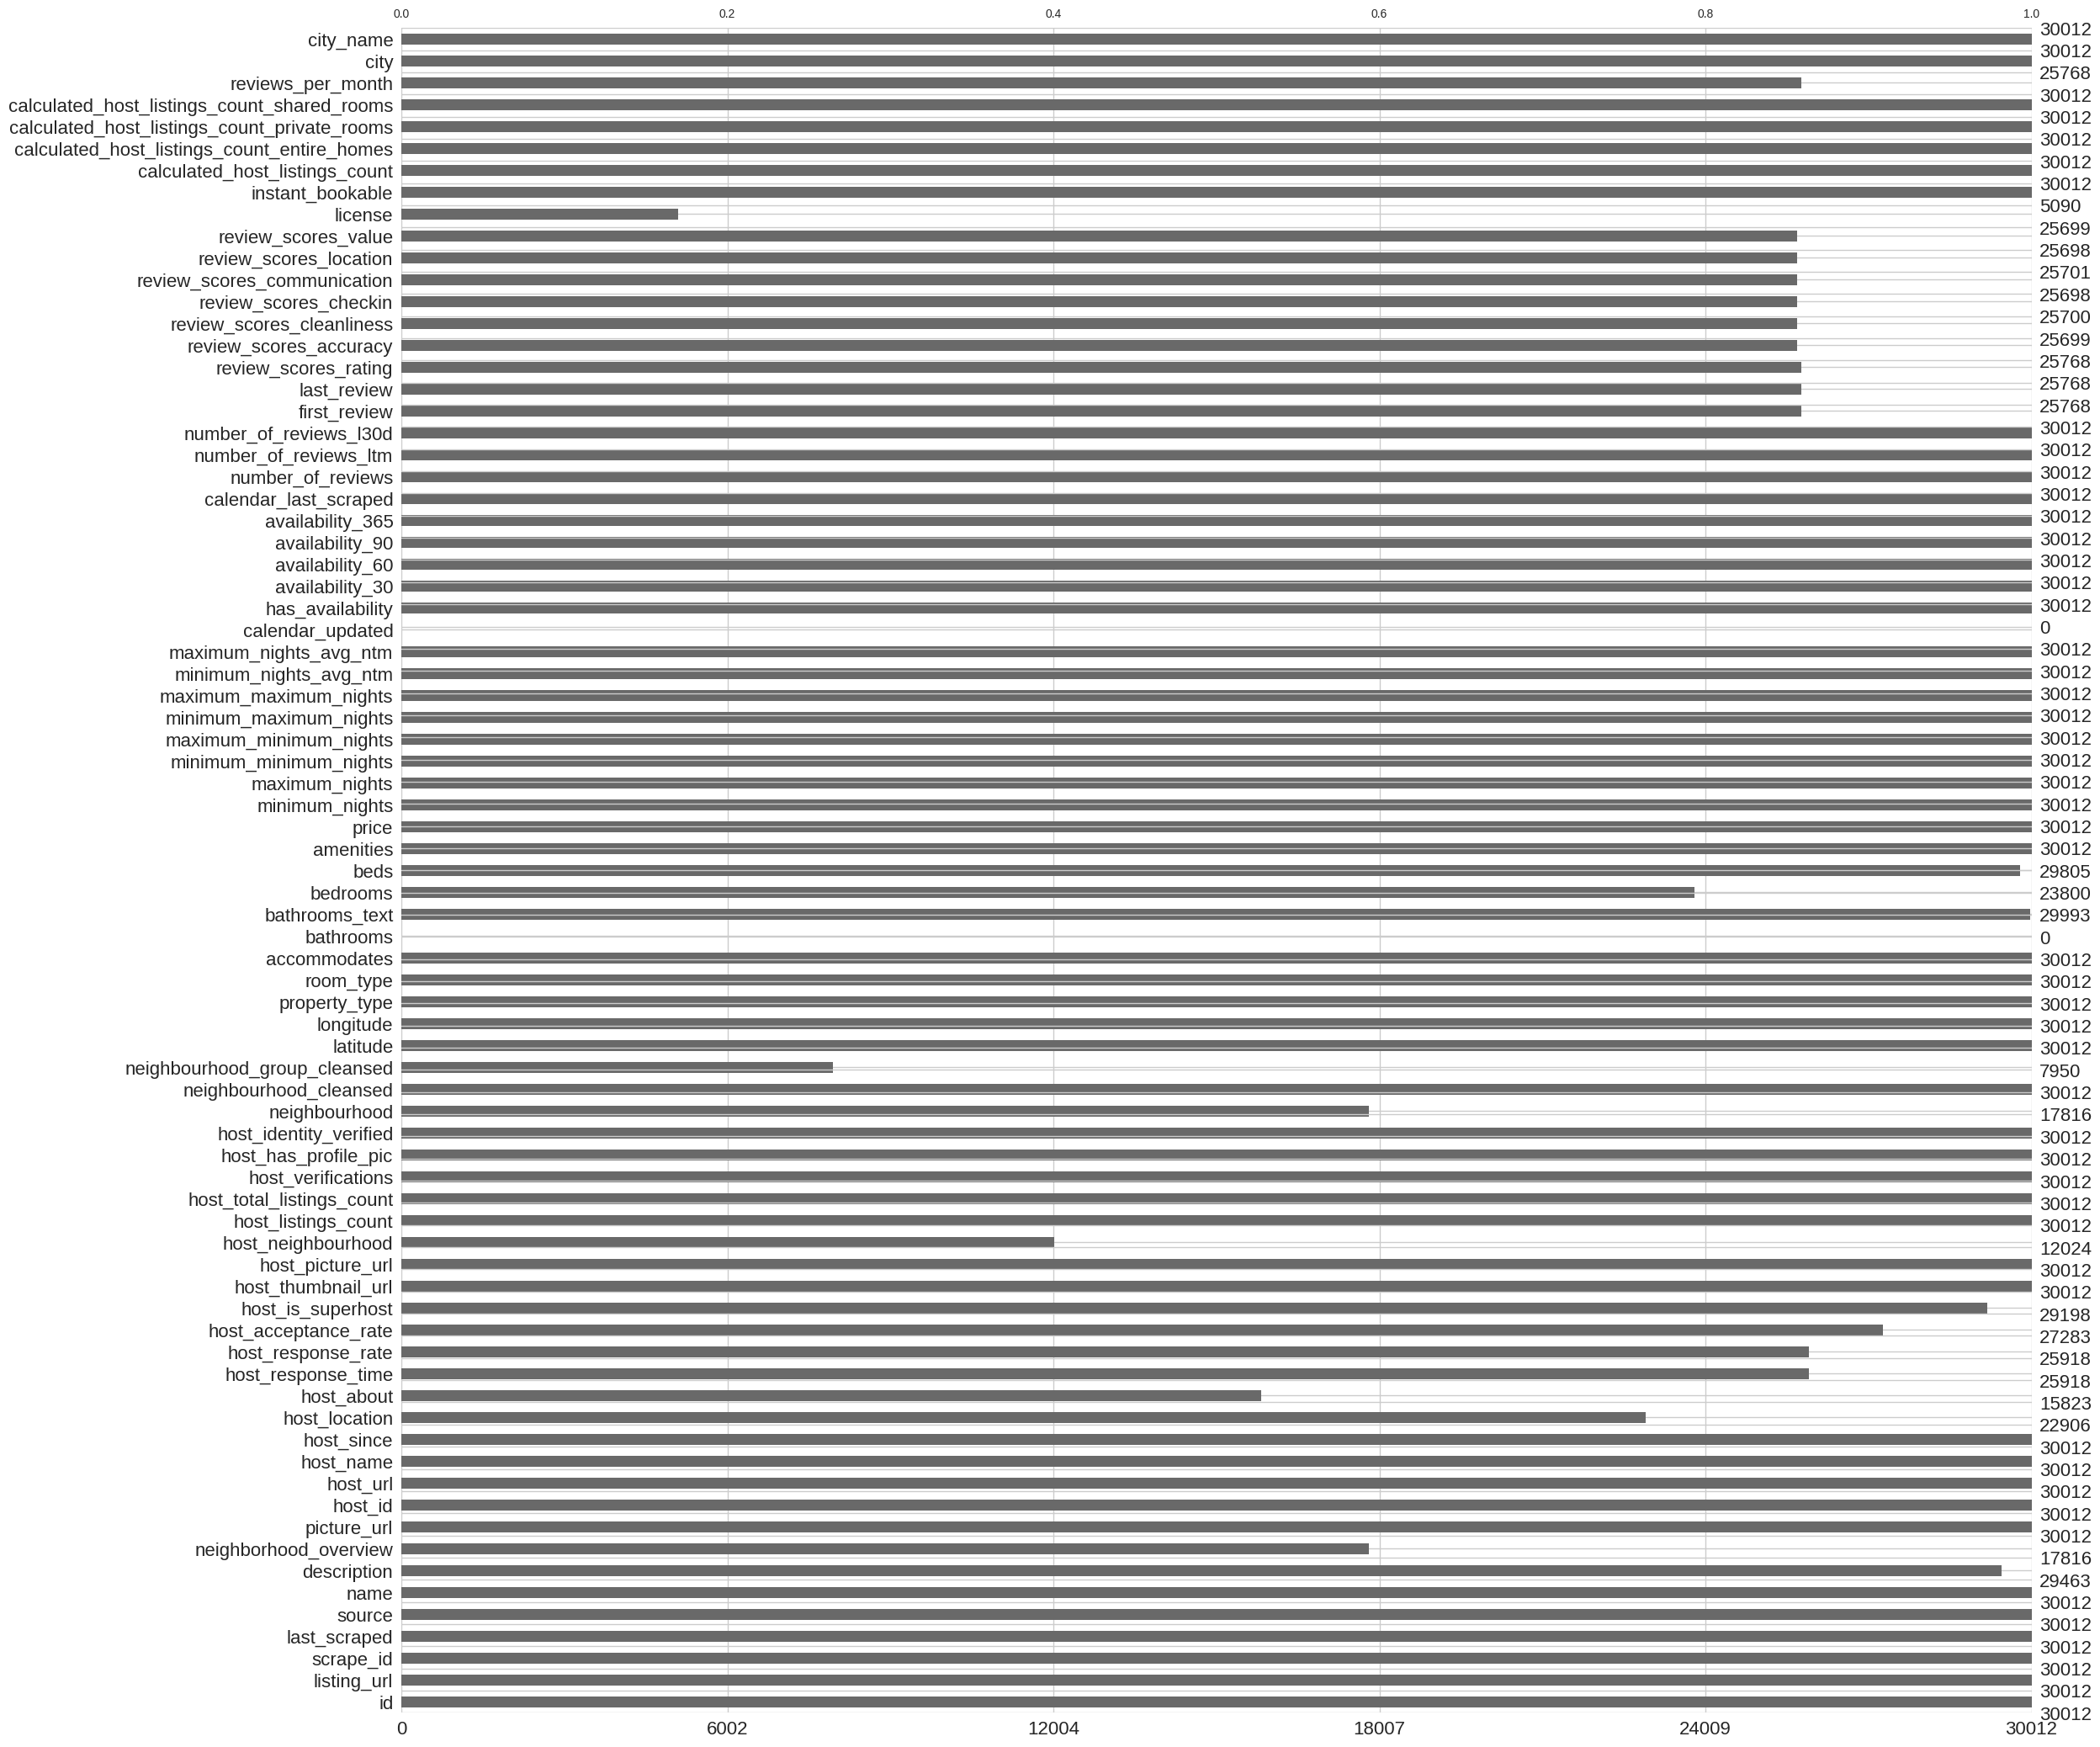

In [ ]:
data.isnull().values.sum()

# column-wise summary of missing values
data.isna().sum()

# visualize using msno package, no need in this case, just give for demo purpose.
msno.bar(data)

In the above graph, it is clear that some csv columns are empty. This is from the original dataset from InsideAirBnB and is not a fault of data exploration.
These columns, calendar_updated and bathrooms, will be removed as they do not provide context to the regression model as they are too sparse.

In [ ]:
columns_to_drop = ['calendar_updated', 'bathrooms']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


## Step 2 : Attribute Analysis

In this step, we will visual the data to determine if normalization, standardization, or feature scaling needs to occur.

In [ ]:
def visualize_norm(X, column): #Takes in data['price], column should be 'price'
    fig = px.box(X, y=column)
    fig2 = px.histogram(X, x=column)
    print("Skew of the rental price data is: ",skew(X, axis=0, bias=True))
    #data.skew(axis=0)
    fig.show()
    fig2.show()


def normality(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()


From the box plot, it is clear that the data must be transformed to perform feature engineering. A logarithmic transformation will be applied to the data to change the distribution to normal, measured by the skewness of the data, and if needed, some outliers will be removed. The skew must also be adjusted.

In [ ]:
data['price'].head(10)

0    $191.00
1     $95.00
2    $105.00
3     $70.00
4     $89.00
5    $110.00
6    $110.00
7    $176.00
8    $174.00
9     $84.00
Name: price, dtype: object

Unforunately, we can't get the stats until the price is converted from a string to an integer type. We'll do that here:

In [ ]:
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float).astype(int)
data['price'].head(10)

0    191
1     95
2    105
3     70
4     89
5    110
6    110
7    176
8    174
9     84
Name: price, dtype: int64

In [ ]:
visualize_norm(data['price'], 'price')

Skew of the rental price data is:  63.39095228159734


<ipython-input-12-ee3701a54dfe>:17: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




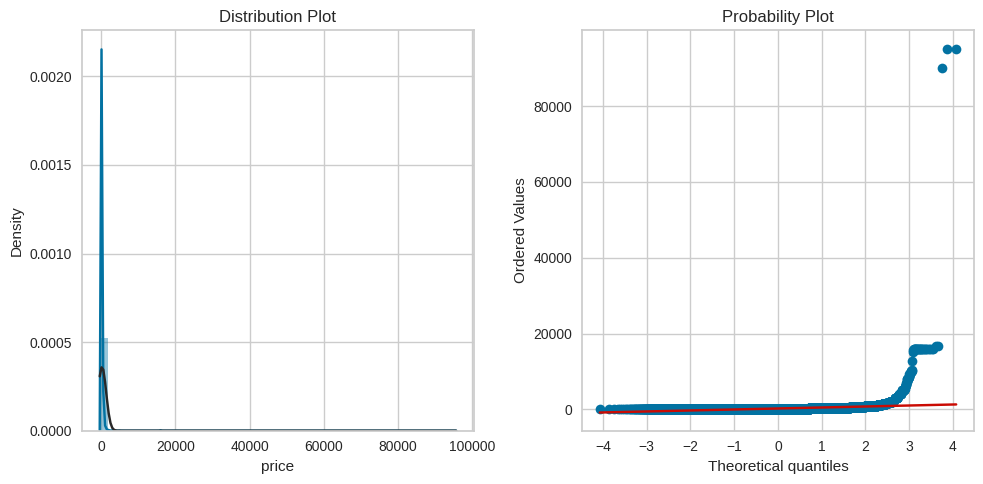

In [ ]:
normality(data['price'])

## Step 4: Check Categorical Attributes

In the regression model, there cannot be any categorical representations, so all the object or category type attributes must be dealt with.

There are a few options with what we can do with all these categorical features:
- Remove them if they're not important to the modelling
- Transform them into numerical features (one-hot encoding, ordinal encoding, mean target encoding)
- Represent as an Embedding
- Use feature hashing

In [ ]:
parsed = data.select_dtypes(include=['object','category'])
for col in parsed.columns:
    print(col) #column names

    #print(parsed[col].value_counts()) # unique values



listing_url
last_scraped
source
name
description
neighborhood_overview
picture_url
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
property_type
room_type
bathrooms_text
amenities
has_availability
calendar_last_scraped
first_review
last_review
license
instant_bookable
city_name


## Step 5: Create New Features

First, deal with amenities as that will be really important for modelling. In Milestone 2, we learned that there are 4546 unique amenities present in the dataset. This is way too many.

We also know that the dataset has additional information on the number of bathrooms, the room type, and the property type - all string type objects. This is all the provided data on the physical characteristics of the AirBnBs so this data will be dealt with together.

First problem: the amenities are just a list of all the amenities in that AirBnb, delimitated by a comma. Therefore, each row is 'unique' so we have to explode view the amenities.

In [ ]:
from ast import literal_eval
data['amenities'] = data['amenities'].apply(literal_eval)

# Explode the 'amenities' column to get each individual amenity
data = data.explode('amenities')

amenities_type_count = data['amenities'].nunique()



In [ ]:
print(f"Number of unique amenity categories present in the dataset: {amenities_type_count} \n")
print(data['amenities'].dtype)

Number of unique amenity categories present in the dataset: 4546 

object


In [ ]:
unique_amenities = data['amenities'].unique()
for amenity in unique_amenities:
    print(amenity)

Hair dryer
Paid parking off premises
Air conditioning
Keypad
Shampoo
Hangers
Lock on bedroom door
Refrigerator
Luggage dropoff allowed
Bed linens
Essentials
Smoke alarm
Fire extinguisher
Private entrance
Cleaning available during stay
Self check-in
Iron
Hot water
TV with standard cable
Cooking basics
Heating
Kitchen
Microwave
Wifi
Coffee maker
Dishes and silverware
TV
Host greets you
Oven
Children’s books and toys
Washer
Dishwasher
Long term stays allowed
High chair
Smoking allowed
Breakfast
Extra pillows and blankets
Room-darkening shades
Ethernet connection
Elevator
Electric stove
Paid parking garage on premises
Dining table
Portable fans
Wine glasses
Drying rack for clothing
Cleaning products
Bidet
Freezer
Body soap
Pets allowed
Conditioner
Dedicated workspace
Central air conditioning
Stove
Paid crib - available upon request
Babysitter recommendations
Private backyard – Fully fenced
Children’s dinnerware
Wifi – 45 Mbps
Free washer – In unit
First aid kit
Paid parking garage on premi

We're going to start with restructuring these amenities to combine some of the categories to make it more feasible to transform them.

In [ ]:
print(data['amenities'].dtype)
print(data['amenities'][0])
print(data['amenities'].iloc[0])

print(type(data['amenities'].iloc[0]))

print(type(data['amenities']))


object
0                        Hair dryer
0         Paid parking off premises
0                  Air conditioning
0                            Keypad
0                           Shampoo
0                           Hangers
0              Lock on bedroom door
0                      Refrigerator
0           Luggage dropoff allowed
0                        Bed linens
0                        Essentials
0                       Smoke alarm
0                 Fire extinguisher
0                  Private entrance
0    Cleaning available during stay
0                     Self check-in
0                              Iron
0                         Hot water
0            TV with standard cable
0                    Cooking basics
0                           Heating
0                           Kitchen
0                         Microwave
0                              Wifi
0                      Coffee maker
0             Dishes and silverware
Name: amenities, dtype: object
Hair dryer
<class 'str'>
<

In [ ]:
count = 0

for col in data.columns:
  print(col)
  count += 1

print(count) #75
#data.drop(columns='wifi', inplace=True)


id
listing_url
scrape_id
last_scraped
source
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
rev

In [ ]:
from fuzzywuzzy import fuzz
data.dropna(subset=['amenities'], inplace=True)

# There are thousands of amenities, but many overlap, so we need to
# simplify them and group them together
amenities1 = [
    "Oven",
    "Refrigerator",
    "Microwave",
    "Toaster",
    "Coffee maker",
    "Dishwasher",
    "Freezer",
    "TV",
    "DVD player",
    "Nintendo Wii",
    "Xbox",
    "PS",
    "Netflix",
    "Amazon Prime Video",
    "Disney+",
    "Hulu",
    "HBO Max",
    "Chromecast",
    "Fire TV",
    "Roku",
    "Sound system",
    "Record player",
    "Body soap",
    "Shampoo",
    "Conditioner",
    "Hair dryer",
    "Towels",
    "BBQ",
    "Pool",
    "Hot tub",
    "Hammock",
    "Kayak",
    "Ping pong table",
    "Bikes",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer"
]

amenities2 = [
    "Iron",
    "Treadmill",
    "Elliptical",
    "Free weights",
    "Yoga mat",
    "High chair",
    "Crib",
    "Baby monitor",
    "Changing Table",
    "Board games",
    "Books",
    "Wifi",
    "Ethernet",
    "Smart lock",
    "Security camera",
    "Alexa device",
    "Google device",
    "Apple TV",
    "HomePod",
    "EV charger",
    "Smoke alarm",
    "Carbon monoxide alarm",
    "Fire extinguisher",
    "First aid kit",
    "Bidet",
    "Sauna",
    "Gas fireplace",
    "Electric fireplace",
    "Wood-burning fireplace",
    "Piano",
    "City view",
    "Sea view"
    "Canal view",
    "Mountain view",
    "River view",
    "Garden view",
    "Pool view",
    "Marina view",
    "Beach access",
    "Free parking",
    "Paid parking",
    "Parking on premises"
]



In [ ]:
def simplify_amenities1(new_data, amenities):
    updated_amenities_data = pd.DataFrame()

    # Iterate through each amenity in the predefined list
    for amenity in amenities1:
        # Create a new column for the amenity and initialize with zeros
        new_data[amenity] = 0

        # Iterate through each row and check if the amenity or a similar string is present
        for index, row in new_data.iterrows():
            # Check if the amenity or a similar string is present in the amenities Series
            for item in row['amenities'].split(','):
                if fuzz.partial_ratio(amenity, item.strip().lower()) >= 80:  # Adjust similarity threshold as needed
                    new_data.at[index, amenity] = 1  # Set the corresponding cell to 1
                    print('Got here', amenity, item)

                    break  # Break the loop if a match is found to avoid redundant checks
        updated_amenities_data = pd.concat([updated_amenities_data, new_data], ignore_index=False)

    updated_amenities_data.to_csv(f'updated_amenities_data.csv', index=False)

    return updated_amenities_data


def simplify_amenities2(new_data, amenities):
    updated_amenities_data = pd.DataFrame()

    # Iterate through each amenity in the predefined list
    for amenity in amenities2:
        # Create a new column for the amenity and initialize with zeros
        new_data[amenity] = 0

        # Iterate through each row and check if the amenity or a similar string is present
        for index, row in new_data.iterrows():
            # Check if the amenity or a similar string is present in the amenities Series
            for item in row['amenities'].split(','):
                if fuzz.partial_ratio(amenity, item.strip().lower()) >= 80:  # Adjust similarity threshold as needed
                    new_data.at[index, amenity] = 1  # Set the corresponding cell to 1
                    print('Got here', amenity, item)

                    break  # Break the loop if a match is found to avoid redundant checks
        updated_amenities_data = pd.concat([updated_amenities_data, new_data], ignore_index=False)

    updated_amenities_data.to_csv(f'updated_amenities_data.csv', index=False)

    return updated_amenities_data
# Example usage
# Assuming 'data' is your DataFrame with the 'amenities' column
# Call the function to simplify amenities and create new columns
new_data = data.copy()
data_with_amenities = simplify_amenities1(new_data, amenities1)
data_with_amenities = simplify_amenities2(new_data, amenities2)

Streaming output truncated to the last 5000 lines.
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair dryer
Got here Hair dryer Hair

In [ ]:
data_with_amenities.to_csv(f'NEW_updated_amenities_data.csv', index=False)


In [ ]:
data_with_amenities.head(10)


In [ ]:
data_with_amenities.shape


In [ ]:
df = pd.read_csv('NEW_updated_amenities_data.csv')

# Initialize a set to keep track of seen IDs
seen_ids = set()

# Iterate through the DataFrame
rows_to_remove = []
for index, row in df.iterrows():
    # Check if the ID has already been seen
    if row['id'] in seen_ids:
        rows_to_remove.append(index)
    else:
        # Add the ID to the set of seen IDs
        seen_ids.add(row['id'])

# Remove rows with duplicate IDs
data = df.drop(rows_to_remove)

# Save the filtered DataFrame back to a CSV file
#data.to_csv('filtered_file.csv', index=False)

In [ ]:
data = pd.read_csv('filtered_file.csv')
data.to_csv('filtered_file.csv', index=False)

<ipython-input-7-9136d28a1735>:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('filtered_file.csv')


In [ ]:
print(data['Hair dryer'][0])
print(data['amenities'][0])
data.head(10)


In [ ]:

data.dropna(subset=['amenities'], inplace=True)

tv_options = ['TV', 'tv', 'television', 'Television']
tv_pattern = '|'.join(tv_options)
'''
# Filter DataFrame based on TV options
tv_categories = data[data['amenities'].str.contains(tv_pattern, case=False)]['amenities'].unique()
print(len(tv_categories))
for category in tv_categories:
    print(category)
'''

"\n# Filter DataFrame based on TV options\ntv_categories = data[data['amenities'].str.contains(tv_pattern, case=False)]['amenities'].unique()\nprint(len(tv_categories))\nfor category in tv_categories:\n    print(category)\n"

Create a new attribute with the TV size.

In [ ]:
tv_rows = data[data['amenities'].str.contains(tv_pattern, case=False)].copy()
tv_rows.dropna(subset=['amenities'], inplace=True)
#print(tv_rows['amenities'])
# Extract TV sizes


tv_sizes = tv_rows['amenities'].str.extract(r'(\d+)')
tv_sizes.fillna(-1, inplace=True)  # Fill missing values with -1 (or any other placeholder value)
tv_sizes = tv_sizes.astype('int64')

# Reset the index of tv_sizes
tv_sizes.reset_index(drop=True, inplace=True)

# Assign TV sizes to 'tv_size' column
data['tv_size'] = tv_sizes

print(data['tv_size'].nunique())
print(data['tv_size'].unique())



17
[-1. 40. 32. 42. 75. 55. 22. 48. 38. 43. 70. 18. 49. 50. 28. 65. 24. nan]


#### Room type:
There's only four types of rooms in the dataset, so one-hot encoding will be used.

In [ ]:
print(data['room_type'].head(10))
print(data['room_type'].nunique())
print(data['room_type'].unique())
#['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']


0       Private room
1    Entire home/apt
2    Entire home/apt
3         Hotel room
4       Private room
5       Private room
6    Entire home/apt
7    Entire home/apt
8    Entire home/apt
9    Entire home/apt
Name: room_type, dtype: object
4
['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']


In [ ]:
pd.get_dummies(data['room_type'])



Entire home/apt  Hotel room  Private room  Shared room
0                False       False          True        False
1                 True       False         False        False
2                 True       False         False        False
3                False        True         False        False
4                False       False          True        False
...                ...         ...           ...          ...
29981             True       False         False        False
29982             True       False         False        False
29983             True       False         False        False
29984             True       False         False        False
29985             True       False         False        False

[29935 rows x 4 columns]

#### Property Type
There are 71 types of properties available. However, this category can be restructured because many of these property types are just the room type described above, with the true property type.

For example, 'Shared room in hostel' and 'Private room in hostel' are currently two different categories but could be one because private and shared rooms are already known.

Thus, this category will be restructured then one-hot encoded.

In [ ]:
print(data['property_type'].head(10))
print(data['property_type'].nunique())
print(data['property_type'].unique())


0    Private room in serviced apartment
1                    Entire rental unit
2                          Entire condo
3             Room in bed and breakfast
4                  Private room in home
5                  Private room in home
6                    Entire rental unit
7                    Entire rental unit
8                          Entire condo
9                    Entire rental unit
Name: property_type, dtype: object
71
['Private room in serviced apartment' 'Entire rental unit' 'Entire condo'
 'Room in bed and breakfast' 'Private room in home'
 'Private room in bed and breakfast' 'Private room in rental unit'
 'Entire villa' 'Entire loft' 'Entire home' 'Entire serviced apartment'
 'Room in boutique hotel' 'Private room in guest suite'
 'Private room in townhouse' 'Private room in condo'
 'Entire vacation home' 'Entire cottage' 'Entire guest suite'
 'Private room' 'Private room in loft' 'Private room in guesthouse'
 'Private room in farm stay' 'Room in serviced apartment'


Remove the 'Shared/ Private room in...' and the 'Entire' prefixes. These are already included in the room_type column. This gets it down to 59 property types.

In [ ]:
data['property_type'] = [category.split(' in ')[-1] if ' in ' in category else category for category in data['property_type']]
print(data['property_type'].nunique())
print(data['property_type'].unique())


59
['serviced apartment' 'Entire rental unit' 'Entire condo'
 'bed and breakfast' 'home' 'rental unit' 'Entire villa' 'Entire loft'
 'Entire home' 'Entire serviced apartment' 'boutique hotel' 'guest suite'
 'townhouse' 'condo' 'Entire vacation home' 'Entire cottage'
 'Entire guest suite' 'Private room' 'loft' 'guesthouse' 'farm stay'
 'tiny home' 'Entire guesthouse' 'Entire townhouse' 'aparthotel'
 'Entire place' 'Tiny home' 'Shared room' 'hotel' 'resort' 'villa'
 'Entire cabin' 'Entire bed and breakfast' 'vacation home'
 'Entire bungalow' 'Dome' 'Farm stay' 'Tent' 'hostel' 'earthen home'
 'Entire home/apt' 'casa particular' 'Castle' 'Camper/RV'
 'Casa particular' 'Tower' 'cabin' 'Boat' 'boat' 'Earthen home'
 'nature lodge' 'Dammuso' 'Houseboat' 'dome' 'pension' 'heritage hotel'
 'chalet' 'Entire chalet' 'Floor']


In [ ]:
data['property_type'] = [category.split(' ', 1)[-1] if category.startswith('Entire ') else category for category in data['property_type']]
print(data['property_type'].nunique())
print(data['property_type'].unique())

46
['serviced apartment' 'rental unit' 'condo' 'bed and breakfast' 'home'
 'villa' 'loft' 'boutique hotel' 'guest suite' 'townhouse' 'vacation home'
 'cottage' 'Private room' 'guesthouse' 'farm stay' 'tiny home'
 'aparthotel' 'place' 'Tiny home' 'Shared room' 'hotel' 'resort' 'cabin'
 'bungalow' 'Dome' 'Farm stay' 'Tent' 'hostel' 'earthen home' 'home/apt'
 'casa particular' 'Castle' 'Camper/RV' 'Casa particular' 'Tower' 'Boat'
 'boat' 'Earthen home' 'nature lodge' 'Dammuso' 'Houseboat' 'dome'
 'pension' 'heritage hotel' 'chalet' 'Floor']


Remove the ones in the room_type list:

In [ ]:
# List of categories to remove
categories_to_remove = ['Private room', 'Entire home/apt', 'Hotel room', 'Shared room']

# Filter the DataFrame by removing rows with specified categories
data = data[~data['property_type'].isin(categories_to_remove)]

In [ ]:
print(data['property_type'].nunique())
print(data['property_type'].unique())

44
['serviced apartment' 'rental unit' 'condo' 'bed and breakfast' 'home'
 'villa' 'loft' 'boutique hotel' 'guest suite' 'townhouse' 'vacation home'
 'cottage' 'guesthouse' 'farm stay' 'tiny home' 'aparthotel' 'place'
 'Tiny home' 'hotel' 'resort' 'cabin' 'bungalow' 'Dome' 'Farm stay' 'Tent'
 'hostel' 'earthen home' 'home/apt' 'casa particular' 'Castle' 'Camper/RV'
 'Casa particular' 'Tower' 'Boat' 'boat' 'Earthen home' 'nature lodge'
 'Dammuso' 'Houseboat' 'dome' 'pension' 'heritage hotel' 'chalet' 'Floor']


Fix the capitalization grammar to combine categories like 'earthen home' and 'Earthen home'

In [ ]:
data['property_type'] = [category.title() for category in data['property_type']]


In [ ]:
print(data['property_type'].nunique())
print(data['property_type'].unique())

38
['Serviced Apartment' 'Rental Unit' 'Condo' 'Bed And Breakfast' 'Home'
 'Villa' 'Loft' 'Boutique Hotel' 'Guest Suite' 'Townhouse' 'Vacation Home'
 'Cottage' 'Guesthouse' 'Farm Stay' 'Tiny Home' 'Aparthotel' 'Place'
 'Hotel' 'Resort' 'Cabin' 'Bungalow' 'Dome' 'Tent' 'Hostel' 'Earthen Home'
 'Home/Apt' 'Casa Particular' 'Castle' 'Camper/Rv' 'Tower' 'Boat'
 'Nature Lodge' 'Dammuso' 'Houseboat' 'Pension' 'Heritage Hotel' 'Chalet'
 'Floor']


Create buckets to group these property types together

In [ ]:
categories = {
    'trad_property_type': ['Serviced Apartment', 'Rental Unit', 'Condo', 'Bed And Breakfast', 'Home',
                    'Villa', 'Loft', 'Guest Suite', 'Townhouse', 'Vacation Home', 'Aparthotel',
                    'Place', 'Hotel', 'Resort', 'Bungalow', 'Home/Apt'],

    'novel_property_type': ['Tiny Home', 'Dome', 'Earthen Home', 'Tower', 'Boat',
              'Nature Lodge', 'Dammuso', 'Houseboat', 'Pension'],

    'heritage_property_type': ['Villa', 'Boutique Hotel', 'Casa Particular', 'Castle', 'Heritage Hotel', 'Chalet'],

    'rustic__property_type': ['Farm Stay', 'Hotel', 'Resort', 'Cabin', 'Tent', 'Camper/Rv', 'Nature Lodge', 'Floor']
}

# Iterate through the rows and encode categories
encoded_data = pd.DataFrame()
for category, property_types in categories.items():
    for property_type in property_types:
        encoded_data[category] = data['property_type'].apply(lambda x: 1 if x in property_types else 0)

# Concatenate with original DataFrame
data = pd.concat([data, encoded_data], axis=1)

In [ ]:
count_zero = (data['rustic__property_type'] == 1).sum()

print(f" rustic__property_type has {count_zero} occurrences of '1'")

count_zero = (data['heritage_property_type'] == 1).sum()
print(f" heritage_property_type has {count_zero} occurrences of '1'")

count_zero = (data['novel_property_type'] == 1).sum()
print(f" novel_property_type has {count_zero} occurrences of '1'")


 rustic__property_type has 428 occurrences of '1'
 heritage_property_type has 556 occurrences of '1'
 novel_property_type has 177 occurrences of '1'


These are the final property categories.

In [ ]:
data.drop(columns=['property_type'], inplace=True)

#### Bathroom Text
Using the regular expression (regex) Python functionality to extract the integers from the bathrooms_text column and convert them to numerical representation

In [ ]:
data['bathrooms_text'].head(10) #extract and convert to a numerical feature without encoding


0    1 private bath
1            1 bath
2           2 baths
3    1 private bath
4           0 baths
5    1 private bath
6            1 bath
7            1 bath
8            1 bath
9            1 bath
Name: bathrooms_text, dtype: object

In [ ]:
data['bathrooms'] = data['bathrooms_text'].str.extract(r'(\d+)').astype(float)
#print(data['bathrooms'],data['bathrooms_text'])


It is clear from the data above that some of the 'bathroom_text' features include 'private' and some do not.

A private bathroom is clearly an attractive feature of an AirBnB therefore this likely affects the listing price. However, some of the listings that do not say that the bathroom is private are full houses or hotel rooms, so they most likely do have a private bathroom, it is just not listed. This doesn't apply to every case.

Rather than create a feature called privateBathroom that only includes those bathrooms that are listed as private- a new feature will be created: private_bathroom_listed which accounts for listed bathroom or full houses or hotels.



In [ ]:
data['private_bathroom_listed'] = data['bathrooms_text'].str.contains('private') | data['room_type'].equals('Entire home/apt') | data['room_type'].equals('Hotel room')



In [ ]:
data.drop(columns='bathrooms_text', inplace=True)

Now let's see where we're at with converting the categorical features to numerical features.

In [ ]:
parsed = data.select_dtypes(include=['object','category'])
for col in parsed.columns:
    print(col) #column names


listing_url
last_scraped
source
name
description
neighborhood_overview
picture_url
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
room_type
amenities
has_availability
calendar_last_scraped
first_review
last_review
license
instant_bookable
city_name


### Host Data
From the object data, we can see there's all of this information provided on the host that may or may not be important.

host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_verifications
host_has_profile_pic
host_identity_verified

In [ ]:
selected_columns = [
    'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
    'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
    'host_identity_verified'
]

# Use loc to select the specified columns
selected_df = data.loc[:, selected_columns]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

                                     host_url     host_name  host_since  \
0    https://www.airbnb.com/users/show/380378  Officina 360  2011-02-07   
1     https://www.airbnb.com/users/show/99235         Lucia  2010-03-26   
2  https://www.airbnb.com/users/show/13925330        Cesare  2014-04-05   

     host_location                                         host_about  \
0  Florence, Italy  360 Rentals has been offering fully furnished ...   
1  Florence, Italy  I was born and raised in the beautiful Florenc...   
2  Florence, Italy                                                  .   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour               100%                  99%   
1     within an hour               100%                  59%   
2     within an hour               100%                  81%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/3bf50...   
1

There is immediately information that can be removed as it has no bearing on the model. The host_url (the link to the AirBnB listing) has no effect on the model, as it will just provide data already in the dataset, unless it's missing. The same can be said for the host_thumbnail_url (an image of the host). The host_thumbnail_url and the host_picture_url are duplicates so the host_picture_url will be deleted.

In [ ]:
data['host_url'] = data['host_url'].apply(lambda x: (0 and print(f"Empty host_url at index {index}: {row['host_url']}")) if pd.isna(x) else 1)
data['host_thumbnail_url'] = data['host_thumbnail_url'].apply(lambda x: (0 and print(f"Empty host_thumbnail_url at index {index}: {row['host_thumbnail_url']}")) if pd.isna(x) else 1)

# Drop the 'host_picture_url' column
data.drop('host_picture_url', axis=1, inplace=True)

Next, we're going to take the categories that have 't' or 'f' strings denoting True or False and convert those to boolean values. This applies to host_is_superhost, host_has_profile_pic, host_identity_verified. host_has_profile_pic will be deleted as it replicates host_thumbnail_url.

Although these may not be directly correlated to the model, they may affect the predictive ability of the model.

In [ ]:
bool_mapping = {'t': 1, 'f': 0}

# Apply the mapping to the specified columns
columns_to_convert = ['host_is_superhost', 'host_identity_verified']
for column in columns_to_convert:
    data[column] = data[column].map(bool_mapping)

In [ ]:
data.drop('host_has_profile_pic', axis=1, inplace=True)

The host_name isn't important, they can be tracked by the host_id, that column can be dropped. The host_since (the date since which the host has been active) can be converted from a string to a integer denoting the year since active. The host_about can be converted into boolean to denote if there is a description.

In [ ]:
data.drop('host_name', axis=1, inplace=True)
data['host_since'] = pd.to_datetime(data['host_since']).dt.year
data['host_about'] = data['host_about'].apply(lambda x: (0 and print(f"Empty host_about at index {index}: {row['host_about']}")) if pd.isna(x) else 1)


host_response_rate and host_acceptance_rate are both percentages from 0-100% and currentlly string objects. Convert these from strings into integers using regex.

In [ ]:
data['host_response_rate'] = data['host_response_rate'].str.extract(r'(\d+)').astype(float)
data['host_acceptance_rate'] = data['host_acceptance_rate'].str.extract(r'(\d+)').astype(float)

We still have host_location, host_response_time, host_neighbourhood, and host_verifications left to convert to numerical features.

The host_location should match with the city_name (ie: AirBnB is in Florence, host is in Florence) in most cases, so change those into the city number provided in the original dataset (Florence= 1, etc.) and find cases where the host isn't from one of those cities and convert into own distinct number representations.

For host_response_time and host_verifications, there should be a limited number of options (seems like host_verifications has two options: phone and email from data exploration) so perform further data exploration and probably one-hot encode if feasible.

host_neighbourhood will be dealt with at the same time as airbnb neighbourhood to create a new feature to denote if the host lives in the same neighbourhood as the airbnb.

In [ ]:
#from Milestone 2:
#city_map = {1: 'Florence', 2: 'Naples', 3: 'Venice'}
city_map = {'Florence': 1, 'Naples': 2, 'Venice': 3}
#currently in "Florence, Italy" format


#data['host_location'] = data['host_location'].str.split(',').str[0]
#data['host_location'] = data['host_location'].map(city_map)

#distinct_number = 4  # Start from 3 for distinct numbers
#3for city in data['host_location'].str.split(',').str[0].unique():
#    if city not in city_map:
#        city_map[city] = distinct_number
#        distinct_number += 1

#There's almost 500 different locations! that's way too many
print(data['host_location'].str.split(',').str[0].unique())

#Get the three original cities, and then everywhere else will just be the country
def get_location(row):
    if pd.notna(row['host_location']):
        city = row['host_location'].split(',')[0].strip() #Get the city, see if it matches Florence, Naples, Venice
        if city in city_map:
            return city_map[city]
        else:
            try:
                  country = row['host_location'].split(',')[1].strip() #if not an og city, just use country
                  if country == 'Italy':
                      return 4
                  # European countries
                  elif country in ['France', 'Switzerland', 'Netherlands', 'Belgium', 'Germany', 'Spain', 'Estonia',
                                  'United Kingdom', 'Ireland', 'Finland', 'Greece', 'Portugal', 'Poland', 'Denmark',
                                  'Norway', 'Czechia', 'Malta', 'Austria', 'Croatia', 'Ukraine']:
                      return 5
                  # North America (including Canada and US states)
                  elif country in ['Canada', 'United States', 'CA', 'HI', 'FL', 'IL', 'TX', 'MI', 'NY', 'DC', 'OR', 'MA', 'AZ', 'SC', 'GA',
                                  'KS', 'OK', 'NJ', 'IN',  'Mexico' ]:
                      return 6
                  #South America
                  elif country in ['Cuba', 'Bolivia', 'Peru',  'Panama', 'Ecuador', 'Guatemala' ]:

                      return 7
                  # Asia & Oceania
                  elif country in ['Japan', 'Turkey', 'Australia', 'Israel', 'United Arab Emirates', 'India',
                                  'Kazakhstan',  'Thailand', 'Qatar', 'Philippines', 'Zimbabwe', ]:
                      return 8
            except IndexError:
                  return np.nan

# Apply the function to create a new column with city numbers or country names
data['host_location_code'] = data.apply(get_location, axis=1)


data.drop(columns=['host_location'], inplace=True)
print(city_map)


['Florence' 'Paris' 'Rome' 'Firenze' 'Viareggio' 'Agliana' 'Turin'
 'Sesto Fiorentino' 'Milan' 'Toscana' 'San Francisco' 'Montemurlo'
 'San Casciano in Val di Pesa' 'Italy' 'Austria' 'Impruneta'
 'Haiku-Pauwela' 'Castiglion Fiorentino' 'Cape Town' 'Vevey' 'Tuscany' nan
 'Lido di Camaiore' 'Amsterdam' 'Pisa' 'Arezzo' 'Pescia' 'Casa Vannini'
 'Montreuil' 'Livorno' 'Castelfidardo' 'Chicago' 'Parma' 'Rio de Janeiro'
 'Prato' 'Madrid' 'Seville' 'Tavarnelle' 'Pistoia' 'Pontassieve'
 'San Miniato' 'Reggello' 'United Kingdom' 'Fiesole' 'Arcadia'
 'San Casciano' 'Australia' 'Borgo San Lorenzo' 'Londa' 'Santa Cristina'
 'Berlin' 'Empoli' 'Monteriggioni' 'Brussels' 'Scarperia' 'Frankfurt'
 'Lu Bagnu' 'Scandicci' 'Barcelona' 'Carmignano' 'Vicchio' 'Santa Barbara'
 'Bologna' 'Ireland' 'Figline e Incisa Valdarno' 'Greve' 'Portogruaro'
 'Montespertoli' 'Lastra a Signa' 'Campagna' 'Paganico' 'Delft' 'Signa'
 'Lucca' 'Tokyo' 'Izmir' 'Potenza' 'Montecatini Terme' 'United States'
 'Houston' 'Vercelli' 'V

Map to relevant continent buckets to get how close the host will be to the city. The host will be categorized into one of the following places:

*   One of the three relevant cities (Florence, Venice, Naples)
*   Elsewhere in Italy
*   Elsewhere in Europe
*   The Americas (North or South)
*   Asia
*   Oceania







In [ ]:
print(data['host_location_code'].unique())


# Apply the mapping function to create a new column 'region_code'
#data['host_location_code'] = data['host_location_code'].apply(map_country_to_region)


[ 1.  5.  4.  6. nan  8.  2.  3.  7.]


In [ ]:
count_nan = pd.isna(data['host_location_code']).sum()

print(f" host_location_code has {count_nan} occurrences of 'nan'")

 host_location_code has 7458 occurrences of 'nan'


In [ ]:
data.dropna(subset=['host_location_code'], inplace=True)


In [ ]:
print(data['host_verifications'].unique())

data['host_verifications'] = data['host_verifications'].apply(eval)

# Create new columns for 'phone', 'email', and 'work_email' and initialize with zeros
data['host_verified_phone'] = data['host_verifications'].apply(lambda x: 1 if 'phone' in x else 0)
data['host_verified_email'] = data['host_verifications'].apply(lambda x: 1 if 'email' in x else 0)
data['host_verified_work_email'] = data['host_verifications'].apply(lambda x: 1 if 'work_email' in x else 0)

# Drop the original 'host_verifications' column
data.drop('host_verifications', axis=1, inplace=True)



["['email', 'phone', 'work_email']" "['email', 'phone']" "['phone']"
 "['phone', 'work_email']" "['email']" '[]']


In [ ]:
print(data['host_response_time'].unique())

#base the response times on the apprx. time taken for each category in hours (1 hour, 6 hours, etc.)
response_time_map = {
    'within an hour': 1,
    'within a few hours': 6,
    'within a day': 24,
    'a few days or more': 48,
    np.nan: 0  # Handle missing values
}

# Map the values to numeric codes
data['host_response_time'] = data['host_response_time'].map(response_time_map)


['within an hour' 'within a day' 'within a few hours' nan
 'a few days or more']


In [ ]:
selected_columns = [
    'host_since',  'host_location_code', 'host_about',
    'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_thumbnail_url',
    'host_neighbourhood', 'host_verified_phone', 'host_verified_work_email', 'host_verified_email',
    'host_identity_verified'
]

# Use loc to select the specified columns
selected_df = data.loc[:, selected_columns]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

   host_since  host_location_code  host_about  host_response_time  \
0        2011                 1.0           1                   1   
1        2010                 1.0           1                   1   
2        2014                 1.0           1                   1   

   host_response_rate  host_acceptance_rate  host_is_superhost  \
0               100.0                  99.0                0.0   
1               100.0                  59.0                0.0   
2               100.0                  81.0                1.0   

   host_thumbnail_url          host_neighbourhood  host_verified_phone  \
0                   1              Centro Storico                    1   
1                   1           Gavinana-Galluzzo                    1   
2                   1  Santo Spirito-San Frediano                    1   

   host_verified_work_email  host_verified_email  host_identity_verified  
0                         1                    1                       1  
1          

In [ ]:
parsed = data.select_dtypes(include=['object','category'])
for col in parsed.columns:
    print(col) #column names

    #print(parsed[col].value_counts()) # unique values


listing_url
last_scraped
source
name
description
neighborhood_overview
picture_url
host_neighbourhood
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
room_type
amenities
has_availability
calendar_last_scraped
first_review
last_review
license
instant_bookable
city_name


### Calendar // Datetime Features


These features are strings representing different dates:
last_scraped, calendar_last_scraped,  first_review, last_review. These features are important for the data exploration to ensure viability of using this dataset for a predictive task but do not affect the end users' decisions or the functionality of the model. They can all be dropped.

In [ ]:
different_values = data[data['last_scraped'] != data['calendar_last_scraped']]

# Print the relevant columns for the filtered rows
print(different_values[['last_scraped', 'calendar_last_scraped']])
print("Number of occurences: ",len(different_values))

      last_scraped calendar_last_scraped
229     2023-09-14            2023-09-13
590     2023-09-14            2023-09-13
4122    2023-09-14            2023-09-13
6228    2023-09-14            2023-09-13
9799    2023-09-14            2023-09-13
10258   2023-09-14            2023-09-13
10429   2023-09-14            2023-09-13
10624   2023-09-14            2023-09-13
11248   2023-09-14            2023-09-13
Number of occurences:  9


In [ ]:
data.drop('last_scraped', axis=1, inplace=True)
data.drop('calendar_last_scraped', axis=1, inplace=True)
data.drop('first_review', axis=1, inplace=True)
data.drop('last_review', axis=1, inplace=True)

### Neighbourhood Features

In [ ]:
selected_columns = [
                      'neighborhood_overview', 'host_neighbourhood',
                      'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                      ]

# Use loc to select the specified columns
selected_df = data.loc[:, selected_columns]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

  neighborhood_overview          host_neighbourhood neighbourhood  \
0                   NaN              Centro Storico           NaN   
1                   NaN           Gavinana-Galluzzo           NaN   
2                   NaN  Santo Spirito-San Frediano           NaN   

  neighbourhood_cleansed neighbourhood_group_cleansed  
0         Centro Storico                          NaN  
1      Gavinana Galluzzo                          NaN  
2         Centro Storico                          NaN  


neighbourhood, neighbourhood_overview, and neighbourhood_group_cleansed  provide info on the neighbourhood. A lot of this data is missing and a lot is in Italian.
neighbourhood_group_cleansed will be removed because nearly 75% is missing and there are only two categories past that, both in Italian. This is insufficient to provide accurate data to the user.  

The neighbourhood_overview is there a discription of the neighbourhood' textual data to the user (ie: There are a lot of ice cream shops, etc.). This will become boolean.

The neighbourhood feature will be removed as it is an unparsed copy of neighbourhood_cleansed.

In [ ]:
data['neighborhood_overview'].unique()
nan_count1 = data['neighborhood_overview'].isna().sum()
percent1 = (nan_count1 / len(data)) * 100
print("Count of NaN values in 'neighborhood_overview':", nan_count1, "out of", len(data), "percent of ", percent1, "%")

data['neighbourhood'].unique()
nan_count2 = data['neighbourhood'].isna().sum()
percent2 = (nan_count2 / len(data)) * 100
print("Count of NaN values in 'neighbourhood':", nan_count2, "out of", len(data), "percent of ", percent2, "%")

data['neighbourhood_group_cleansed'].unique()
nan_count3 = data['neighbourhood_group_cleansed'].isna().sum()
percent3 = (nan_count3 / len(data)) * 100
print("Count of NaN values in 'neighbourhood_group_cleansed':", nan_count3, "out of", len(data), "percent of ", percent3, "%")


Count of NaN values in 'neighborhood_overview': 8374 out of 22477 percent of  37.25586154735952 %
Count of NaN values in 'neighbourhood': 8374 out of 22477 percent of  37.25586154735952 %
Count of NaN values in 'neighbourhood_group_cleansed': 16415 out of 22477 percent of  73.03020865773902 %


In [ ]:
data.drop(columns=['neighbourhood_group_cleansed'], inplace=True)
data.drop(columns=['neighbourhood'], inplace=True)

data['neighborhood_overview'] = data['neighborhood_overview'].apply(lambda x: 0 if pd.isna(x) else 1)


Next we have the host neighbourhood and the property neighbourhood. Although it's helpful to know the neighbourhood, the latitude and longitude of the airbnbs will be used to approximate how close the AirBnB is to the city center and give a categorical score. This data could be used to create a feature that approximates how close the host is to the AirBnB, for emergencies or extra help, but that is already in the host_location_code feature previously created. Therefore these can be removed.

In [ ]:
print(data['neighbourhood_cleansed'].unique())
print(data['neighbourhood_cleansed'].unique())


['Centro Storico' 'Gavinana Galluzzo' 'Isolotto Legnaia' 'Campo di Marte'
 'Rifredi' 'San Lorenzo' 'Chiaia' 'San Giuseppe' 'Vomero' 'Porto'
 'Pendino' 'Montecalvario' 'San Ferdinando' 'Avvocata'
 "San Carlo all'Arena" 'Arenella' 'Mercato' 'Posillipo' 'Stella'
 'Zona Industriale' 'Bagnoli' 'Ponticelli' 'Vicaria' 'Fuorigrotta'
 'Poggioreale' 'Secondigliano' 'Pianura' 'San Pietro a Patierno'
 'Piscinola' 'Barra' 'San Giovanni a Teduccio' 'Soccavo' 'Chiaiano'
 'Miano' 'Scampia' 'Cannaregio' 'Castello' 'Lido' 'Dorsoduro' 'San Marco'
 'Piave 1860' 'San Polo' 'Santa Croce' "Sant'Erasmo" "Pra' Secco"
 'San Lorenzo XXV Aprile' "Sant'Elena" 'Alberoni' 'Marghera' 'Aeroporto'
 'Bissuola' 'Murano' 'Giudecca' 'Carpenedo' 'Tessera' 'Campalto'
 "Ca' Emiliani" 'Villaggio Sartori' 'Favaro' 'Malcontenta'
 'Marghera Zona Industriale' 'Altobello' 'Campalto Bagaron' 'Torre Antica'
 'Cipressina' 'Pellestrina' 'Villaggio San Marco' 'Burano' 'Mazzorbo'
 'Santa Barbara' 'Marghera Catene' 'Campalto Gobbi' 'Zelar

In [ ]:
data.drop(columns=['host_neighbourhood'], inplace=True)
data.drop(columns=['neighbourhood_cleansed'], inplace=True)


### Clean & Extract Other Categorical Features

In [ ]:
parsed = data.select_dtypes(include=['object','category'])
for col in parsed.columns:
    print(col) #column names

    #print(parsed[col].value_counts()) # unique values


listing_url
source
name
description
picture_url
room_type
amenities
has_availability
license
instant_bookable
city_name


In [ ]:
selected_columns = ['listing_url', 'source', 'name', 'description',
                       'picture_url',
                       'amenities',
                      'has_availability',
                     'license', 'instant_bookable', 'city_name']

# Use loc to select the specified columns
selected_df = data.loc[:, selected_columns]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

                          listing_url       source  \
0  https://www.airbnb.com/rooms/31840  city scrape   
1  https://www.airbnb.com/rooms/32120  city scrape   
2  https://www.airbnb.com/rooms/32180  city scrape   

                                                name  \
0  Serviced apartment in Florence · ★4.65 · 1 bed...   
1  Rental unit in Florence · ★4.88 · 1 bedroom · ...   
2  Condo in Florence · ★4.77 · 2 bedrooms · 4 bed...   

                                         description  \
0  Nice, private and quiet double room, classic s...   
1  Apartment at a 30 minute walk from Ponte Vecch...   
2  .<br /><br /><b>The space</b><br />If you are ...   

                                         picture_url   amenities  \
0  https://a0.muscache.com/pictures/09da8cb8-47df...  Hair dryer   
1  https://a0.muscache.com/pictures/miso/Hosting-...  Essentials   
2  https://a0.muscache.com/pictures/bcb23395-7215...  Hair dryer   

  has_availability license instant_bookable city_name  
0   

Deal with the urls. These do not provide any information for the model, unless they are missing. Convert to boolean, 1 if present (as the existence of images of the AirBnB will definitely influence the renter), 0 if not.


In [ ]:
data['picture_url'] = data['picture_url'].apply(lambda x: (0 and print(f"Empty picture_url at index {index}: {row['picture_url']}")) if pd.isna(x) else 1)
data['listing_url'] = data['listing_url'].apply(lambda x: (0 and print(f"Empty listing_url at index {index}: {row['listing_url']}")) if pd.isna(x) else 1)



Source isn't important for the modelling because it doesn't affect the user's purchasing decisions. It is only important for the data exploration when determining the viability and reliability of the data set. As such, it was analyzed in Milestone 2 by the group, it can however be removed from this modelling.

In [ ]:
data['source'].unique()
data.drop('source', axis=1, inplace=True)

License can be dropped, it's too sparse to provide data.

In [ ]:
nan_count = data['license'].isna().sum()
percent = (nan_count / len(data)) * 100
print("Count of NaN values in 'license':", nan_count, "out of", len(data), "percent of ", percent, "%")


Count of NaN values in 'license': 18563 out of 22477 percent of  82.58664412510566 %


In [ ]:
data.drop('license', axis=1, inplace=True)

Convert the 't' and 'f' strings into numeric booleans.

In [ ]:
bool_mapping = {'t': 1, 'f': 0}

# Apply the mapping to the specified columns
columns_to_convert = ['instant_bookable', 'has_availability']
for column in columns_to_convert:
    data[column] = data[column].map(bool_mapping)

The features 'name', 'city_name' and 'description' are all textual data that provide the users with more information about the AirBnB. However, as this dataset was scraped from this textual, this information is in the dataset in other features can be dropped.

In [ ]:
data.drop('name', axis=1, inplace=True)
data.drop('city_name', axis=1, inplace=True)
data.drop('description', axis=1, inplace=True)

Drop the data previously restructured.

In [ ]:
data.drop('amenities', axis=1, inplace=True)

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

## Step 6: Feature selection/ creation

All categories are now converted to numerical! Now do an analysis of the full dataset to ensure we're only keeping the most important info.

In [ ]:
data.shape
for col in data.columns:
    print(col) #column names


id
listing_url
scrape_id
neighborhood_overview
picture_url
host_id
host_url
host_since
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_listings_count
host_total_listings_count
host_identity_verified
latitude
longitude
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
city
Induc

### Clean Amenities Features

In [ ]:
different_values = data[data['Induction stove'] != data['induction stove']]

# Print the relevant columns for the filtered rows
print(different_values[['Induction stove', 'induction stove']])
print("Number of occurences: ",len(different_values))

       Induction stove  induction stove
2                    0                1
7                    0                1
9                    0                1
15                   0                1
16                   0                1
...                ...              ...
29957                0                1
29966                0                1
29968                0                1
29972                0                1
29975                0                1

[10091 rows x 2 columns]
Number of occurences:  10091


oops there's copies of the amenities data. The lower case ones are the real ones.

In [ ]:
# List of amenities
amenities = [
    "Induction stove",
    "Electric stove",
    "Gas stove",
    "HDTV",
    "City skyline view",
    "Stove",
    "Oven",
    "Refrigerator",
    "Microwave",
    "Toaster",
    "Coffee maker",
    "Dishwasher",
    "Freezer",
    "TV",
    "DVD player",
    "Nintendo Wii",
    "Xbox",
    "PS",
    "Netflix",
    "Amazon Prime Video",
    "Disney+",
    "Hulu",
    "HBO Max",
    "Chromecast",
    "Fire TV",
    "Roku",
    "Sound system",
    "Record player",
    "Body soap",
    "Shampoo",
    "Conditioner",
    "Hair dryer",
    "Towels",
    "BBQ",
    "Outdoor kitchen",
    "Pool",
    "Hot tub",
    "Hammock",
    "Kayak",
    "Ping pong table",
    "Bikes",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer",
    "Iron",
    "Treadmill",
    "Elliptical",
    "Free weights",
    "Yoga mat",
    "High chair",
    "Crib",
    "Baby monitor",
    "Changing Table",
    "Board games",
    "Books",
    "Wifi",
    "Ethernet",
    "Smart lock",
    "Security camera",
    "Alexa device",
    "Google device",
    "Apple TV",
    "HomePod",
    "EV charger",
    "Smoke alarm",
    "Carbon monoxide alarm",
    "Fire extinguisher",
    "First aid kit",
    "Bidet",
    "Sauna",
    "Gas fireplace",
    "Electric fireplace",
    "Wood-burning fireplace",
    "Piano",
    "City view",
    "Sea view",
    "Canal view",
    "Mountain view",
    "River view",
    "Garden view",
    "Pool view",
    "Marina view",
    "Beach access",
    "Free parking",
    "Paid parking",
    "Parking on premises"
]

for col in data.columns:
    if col in amenities:
        data.drop(columns=[col], inplace=True)



In [ ]:
data.shape
for col in data.columns:
    print(col) #column names


id
listing_url
scrape_id
neighborhood_overview
picture_url
host_id
host_url
host_since
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_listings_count
host_total_listings_count
host_identity_verified
latitude
longitude
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
city
induc

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

### Min/ Max Stay Features
142 columns is probably too many, however 95 of these come from amenities which is very relevant to the topic we're trying to analyse. To minimize the strain on the model, let's try to better formulate the other features.

In [ ]:
columns_to_convert = [
    "minimum_nights", #the min allowable nights by the host
    "maximum_nights", # the max allowable nights by the host
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm", #average min nights booked
    "maximum_nights_avg_ntm" #average max nights booked
]
# Use loc to select the specified columns
selected_df = data.loc[:, columns_to_convert]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))



   minimum_nights  maximum_nights  minimum_minimum_nights  \
0               1              99                       1   
1               1               5                       1   
2               6              31                       6   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                       3                       6                       6   
1                       1                       5                       5   
2                       6                    1125                    1125   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  
0                     2.0                     6.0  
1                     1.0                     5.0  
2                     6.0                  1125.0  


From the InsideAirBnB database, it's known that the four values: minimum_minimum_nights,  maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights are calculated from the calendar provided to provide hosts with a better understanding of their margin, it does not affect the user. These can be dropped.



In [ ]:
data.drop('maximum_minimum_nights', axis=1, inplace=True)
data.drop('minimum_minimum_nights', axis=1, inplace=True)
data.drop('minimum_maximum_nights', axis=1, inplace=True)
data.drop('maximum_maximum_nights', axis=1, inplace=True)

minimum_nights_avg_ntm and maximum_nights_avg_ntm are the average length booked by users over the last 365 days from the day the data was collected. We are calculating the price per night, not overall. As well, the behaviour of other users should be independent from current users, the model should model the price point based on the information available at the time of booking to predict the price per night.

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

### Calculated Host Features

From the Inside Airbnb data dictionary:

In [ ]:
columns_to_convert = [
    "calculated_host_listings_count", #The number of listings the host has in the current scrape, in the city/region geography.
    "calculated_host_listings_count_entire_homes", # The number of Entire home/apt listings the host has in the current scrape, in the city/region geography
    "calculated_host_listings_count_private_rooms", #The number of Private room listings the host has in the current scrape, in the city/region geography
    "calculated_host_listings_count_shared_rooms", #The number of Shared room listings the host has in the current scrape, in the city/region geography
]




# Use loc to select the specified columns
selected_df = data.loc[:, columns_to_convert]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

   calculated_host_listings_count  \
0                              30   
1                               1   
2                               2   

   calculated_host_listings_count_entire_homes  \
0                                           21   
1                                            1   
2                                            2   

   calculated_host_listings_count_private_rooms  \
0                                             9   
1                                             0   
2                                             0   

   calculated_host_listings_count_shared_rooms  
0                                            0  
1                                            0  
2                                            0  


The number of total AirBnBs of a host may affect the price or the reviews as the host may better manage their business after garnering most knowledge, or they may be less able to control each residence. However, the count of listings by housing type do not attribute to the final model and would only move to create a data leak or oversaturate the model. These will be dropped.

In [ ]:
data.drop('calculated_host_listings_count_entire_homes', axis=1, inplace=True)
data.drop('calculated_host_listings_count_private_rooms', axis=1, inplace=True)
data.drop('calculated_host_listings_count_shared_rooms', axis=1, inplace=True)

In [ ]:
for col in data.columns:
    print(col) #column names
data.shape #141

id
listing_url
scrape_id
neighborhood_overview
picture_url
host_id
host_url
host_since
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_listings_count
host_total_listings_count
host_identity_verified
latitude
longitude
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
reviews_per_month
city
induction stove
electric stove
gas stove
oven
refrigerator
microwave
toaster
coffee maker
dishwasher
freezer
tv
hdtv
dvd player
nintendo wii
xbox
ps
netflix
amazon prime video
disney+
hulu
hbo max
chromecast
fire tv
roku
sound sys

(22477, 141)

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

### Create Distance to City Centre Feature

From OpenStreetMap, get the official longitude and latitude of the city center, marked by the most famous landmark in each city of the relevant cities for the dataset. These may not be the exact centre of the city but they approximate the desireable areas that would be popular for tourists, have the most visitors annually in the city based on the statistics provided by the Italian Board of Tourism, and denote the areas that would likely be recommended online and in travel books to tourists.

This design decision does not limit the model to function on the cities selected such that if another city were to be modelled on this dataset, the model would need to be retrained. This is because the OpenStreetMap was utilized, improving the robustness of the model. However, it's important to note that the choice of landmarks may still introduce some level of bias or variability, as popularity and tourist preferences can change over time.

Florence = Duomo Cathedral

Venice = St. Mark's Square

Naples = Naples Cathedral



In [ ]:
!pip install osmnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
from geopy.distance import geodesic

def get_city_center_coordinates(row, city_list):
    city_map = {1: 'Florence', 2: 'Naples', 3: 'Venice'}
    city_real = city_map.get(row['city'], 'Unknown')
    print("city_real", city_real)
    if city_real == 'Unknown':
        print("error")
    # Check if city_real matches any of the cities in city_list
    if city_real in [place_name.split(',')[1].strip() for place_name in city_list]:
        #print("got here")

        # Retrieve street network for the specified city
        place_name = next(place for place in city_list if city_real == place.split(',')[1].strip())
        place_coordinates = ox.geocode(place_name)
        print("coordinates", place_coordinates)

        try:
            # Calculate the distance from the airbnb to the city landmark specified
            airbnb_coords = (row['latitude'], row['longitude'])
            distance_from_centre = geodesic(airbnb_coords, place_coordinates).kilometers
            print("distance", distance_from_centre)
            return distance_from_centre

        except Exception as e:
            print("Error:", e)
            return None

# Has to be in this format to be accepted by OSM
city_list = {"Piazza Duomo, Florence, Italy", "St. Mark's Square, Venice, Italy", "Naples Cathedral, Naples, Italy" }
data['distance_from_city_centre'] = data.apply(get_city_center_coordinates, city_list=city_list, axis=1)

#print("Distance:", data['distance_from_city_centre'])


Streaming output truncated to the last 5000 lines.
coordinates (45.434259100000006, 12.338508894498808)
distance 1.1968312310716982
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 0.35893235672146684
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 0.33980256187183483
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 10.216249588604661
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 3.452593989796911
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 9.605653672891677
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 11.320964890537152
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 1.7613000860520336
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 1.3915689958009005
city_real Venice
coordinates (45.434259100000006, 12.338508894498808)
distance 0.163

In [ ]:
print(data['distance_from_city_centre'].nunique())

21341


In [ ]:
#data.to_csv('filtered_file.csv', index=False)

In [ ]:
data.drop('latitude', inplace=True, axis=1)
data.drop('longitude', inplace=True, axis=1)

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

### Availability Features

In [ ]:
columns_to_convert = [
    "has_availability", #Boolean value (t/f)
    "availability_30", # The availability of the listing x days in the future
    "availability_60", #The availability of the listing x days in the future
    "availability_90", #The availability of the listing x days in the future
    "availability_365" #The availability of the listing x days in the future
]



# Use loc to select the specified columns
selected_df = data.loc[:, columns_to_convert]

# Display the first few rows of the resulting DataFrame
print(selected_df.head(3))

print(len(data['has_availability']=='0'))

   has_availability  availability_30  availability_60  availability_90  \
0                 1                2               30               60   
1                 1                9               22               52   
2                 1                5                7               11   

   availability_365  
0               335  
1                52  
2               275  
22477


The availability may affect the long-term pricing from the host, but will likely not influence the pricing scheme quarterly, bimonthly, or monthly. Thus, only has_availability and availability_365 will be kept.

In [ ]:
data.drop('availability_30', inplace=True, axis=1)
data.drop('availability_60', inplace=True, axis=1)
data.drop('availability_90', inplace=True, axis=1)

In [ ]:
#data.to_csv('filtered_file.csv', index=False)

## Do Null Value Analysis
This is not a typical step but so many new features were created and many features were significantly altered, we must ensure the data is still usable.

In [ ]:
data.drop('scrape_id', inplace=True, axis=1)

<Axes: >

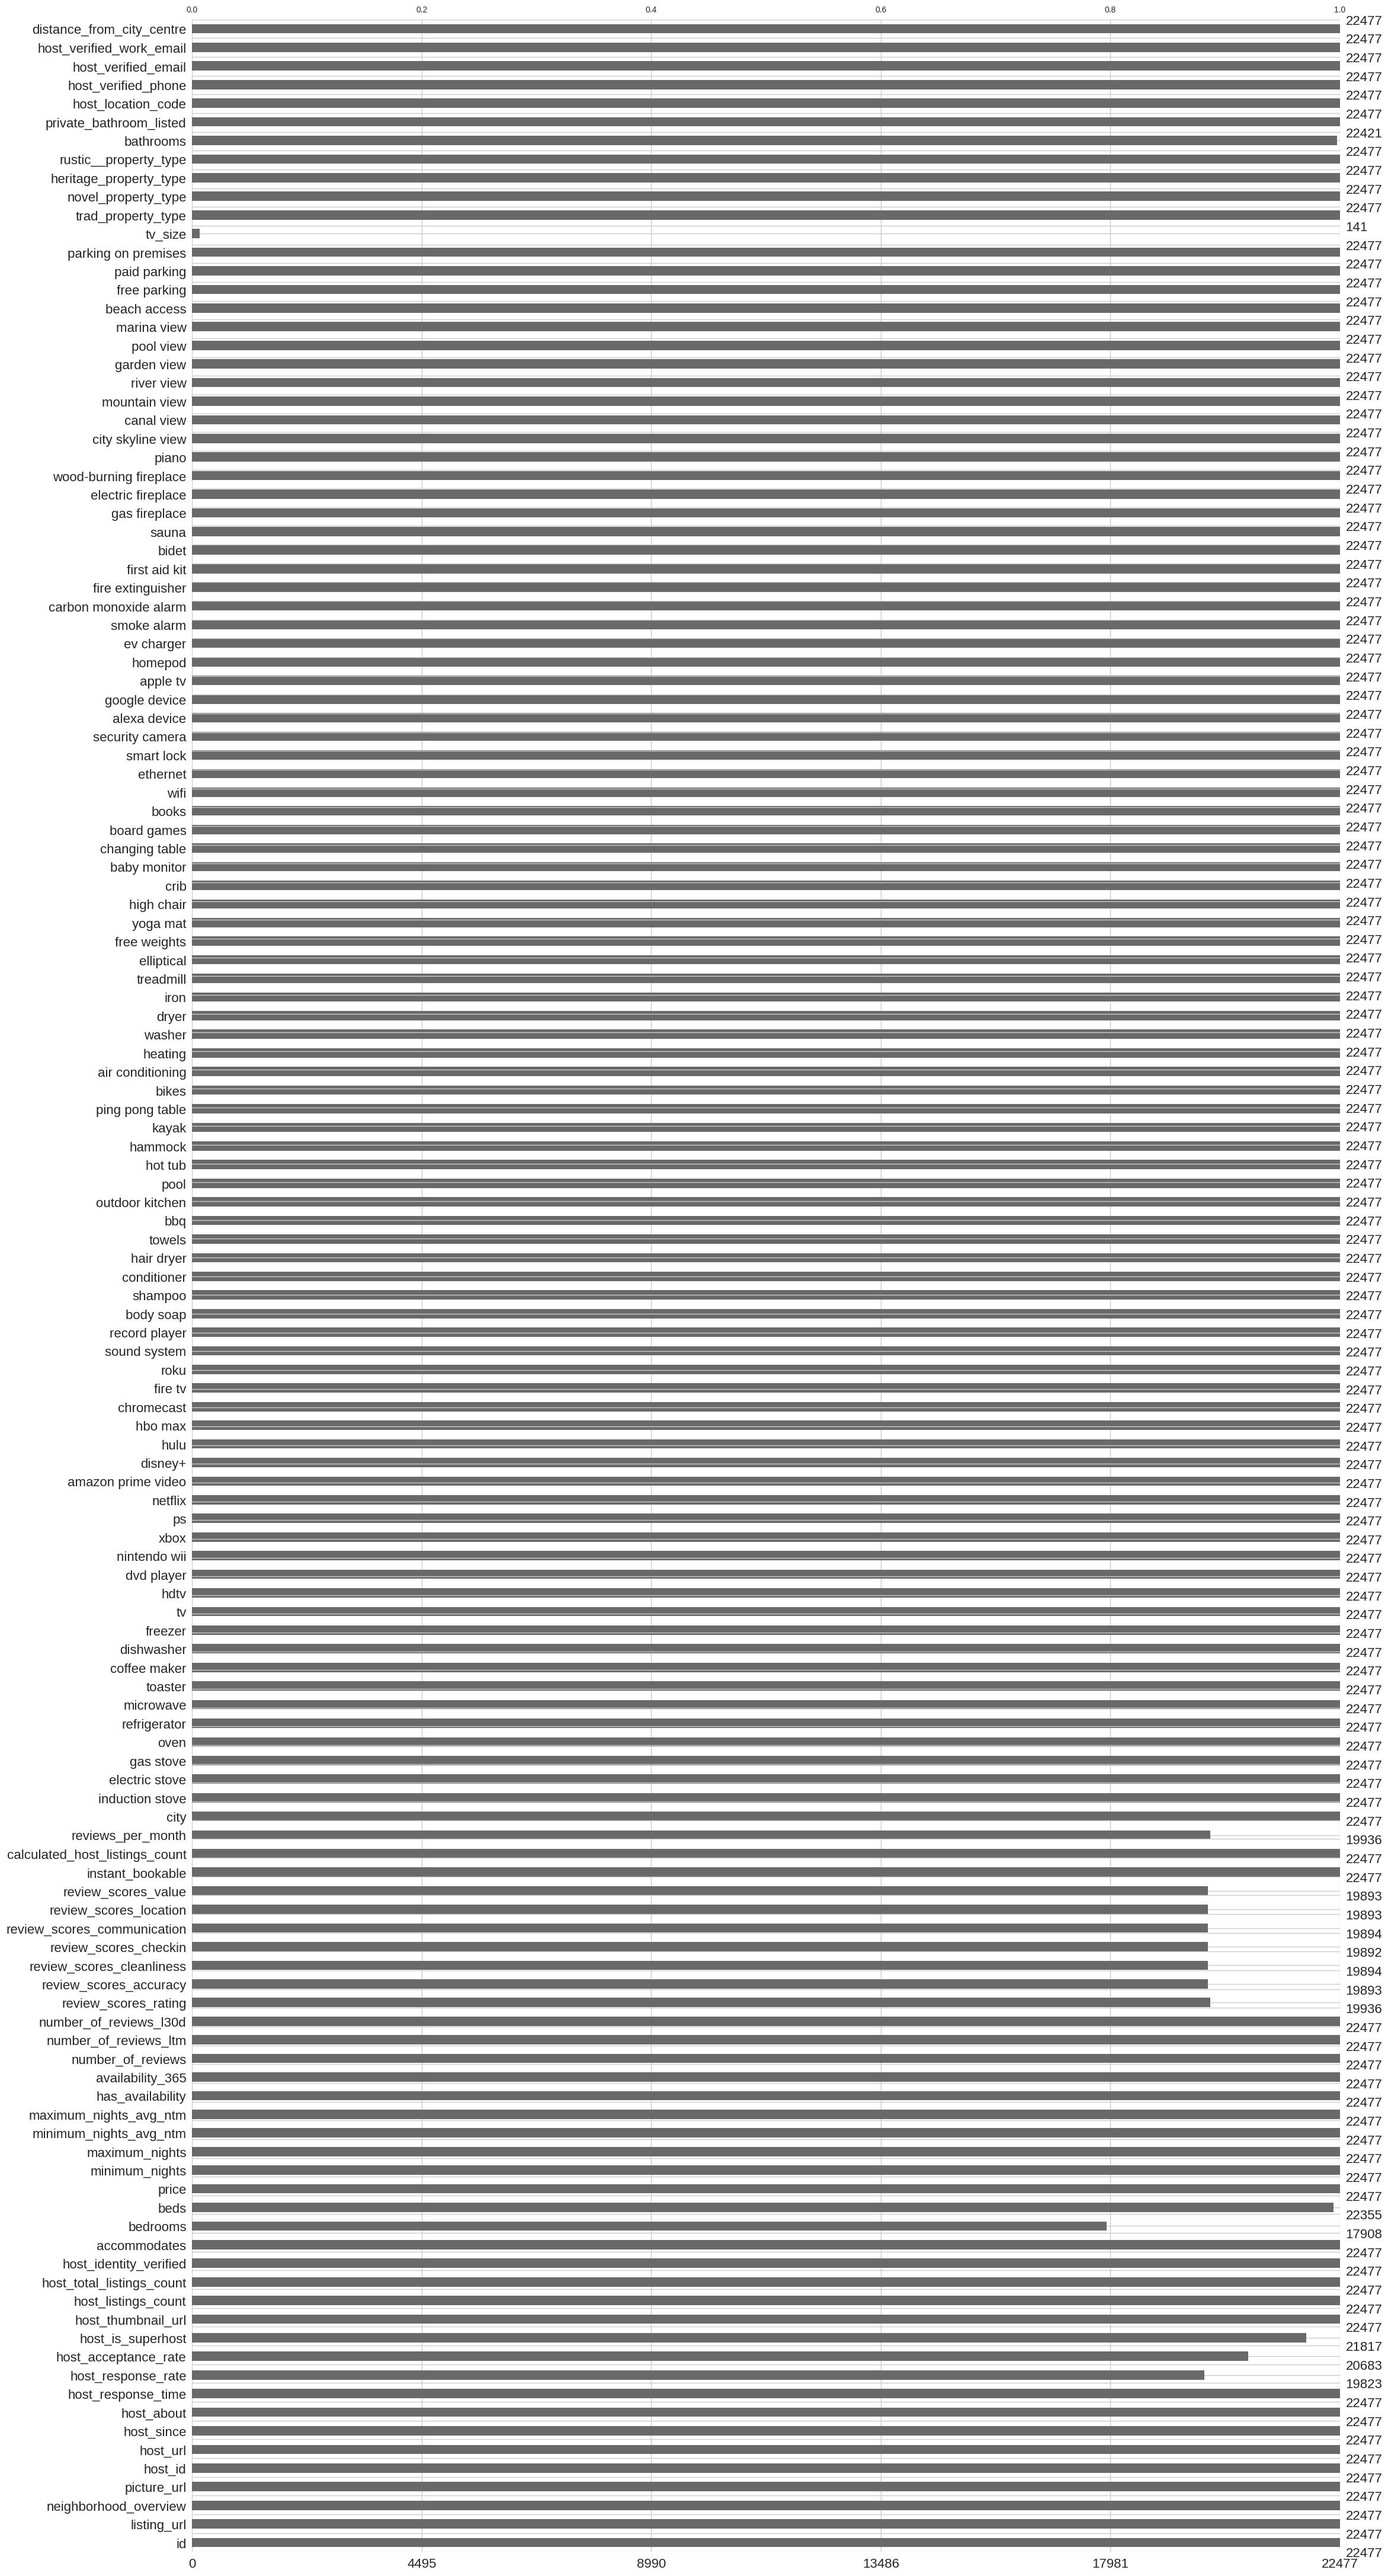

In [ ]:
data.isnull().values.sum()

# column-wise summary of missing values
data.isna().sum()

# visualize using msno package, no need in this case, just give for demo purpose.
msno.bar(data)

As the model will predict the star rating using the review scoring data as a baseline to minimize loss, all data points missing the review data will be dropped. This will still leave 19,800 data points which is more than sufficient for our purposes.

In [ ]:
data.dropna(subset=['review_scores_value'], inplace=True)
data.dropna(subset=['review_scores_location'], inplace=True)
data.dropna(subset=['review_scores_cleanliness'], inplace=True)
data.dropna(subset=['review_scores_rating'], inplace=True)


In [ ]:
#data.to_csv('filtered_file.csv', index=False)

### Correlation between numeric attributes

<Axes: >

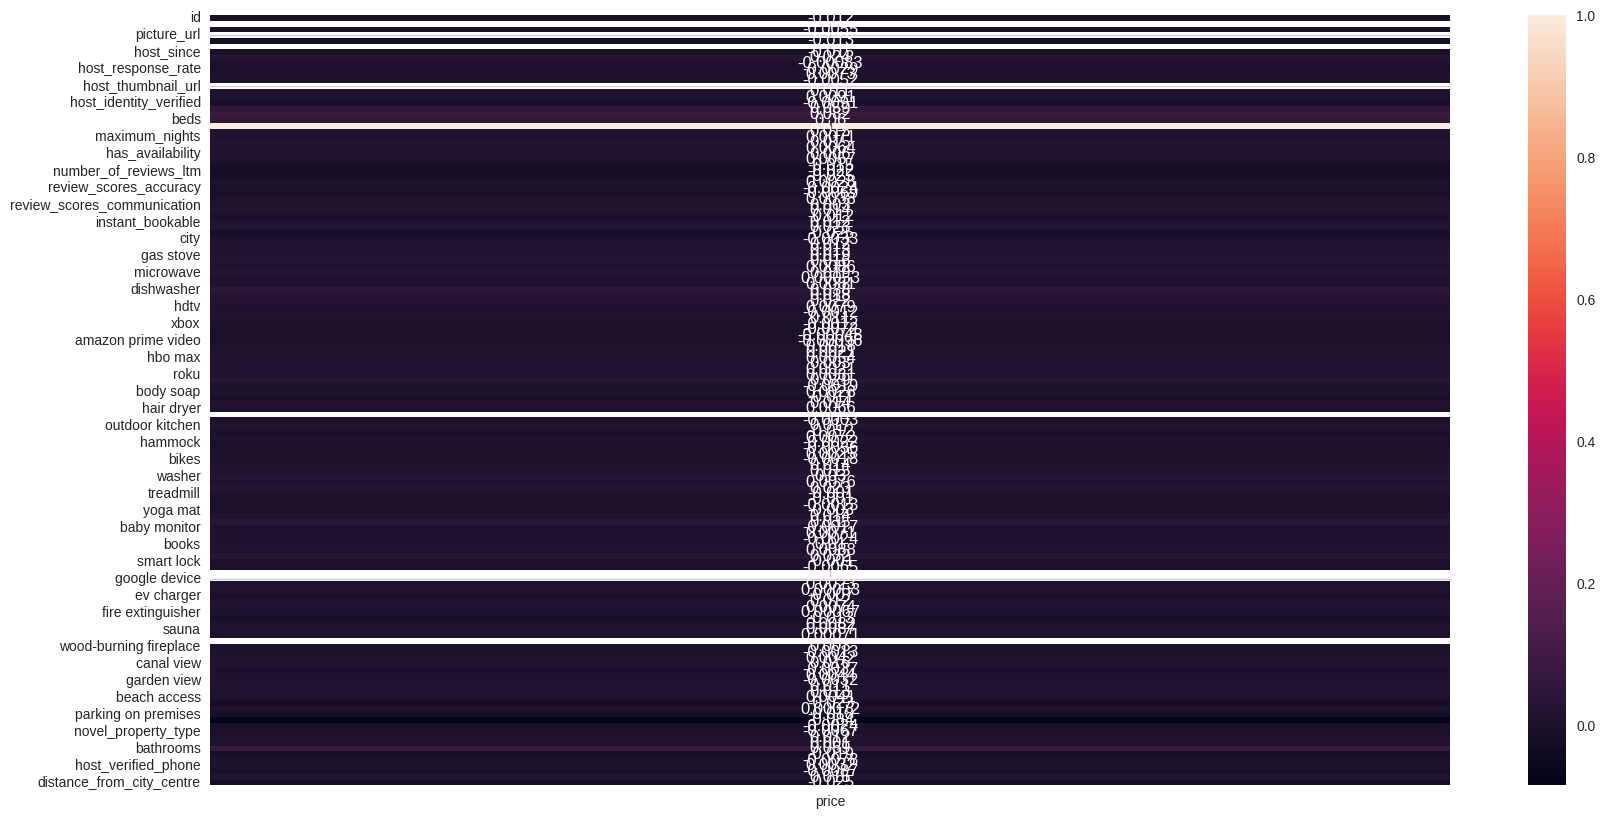

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
corr = data.corr()[['price']]
sns.heatmap(corr, annot=True)

<Axes: >

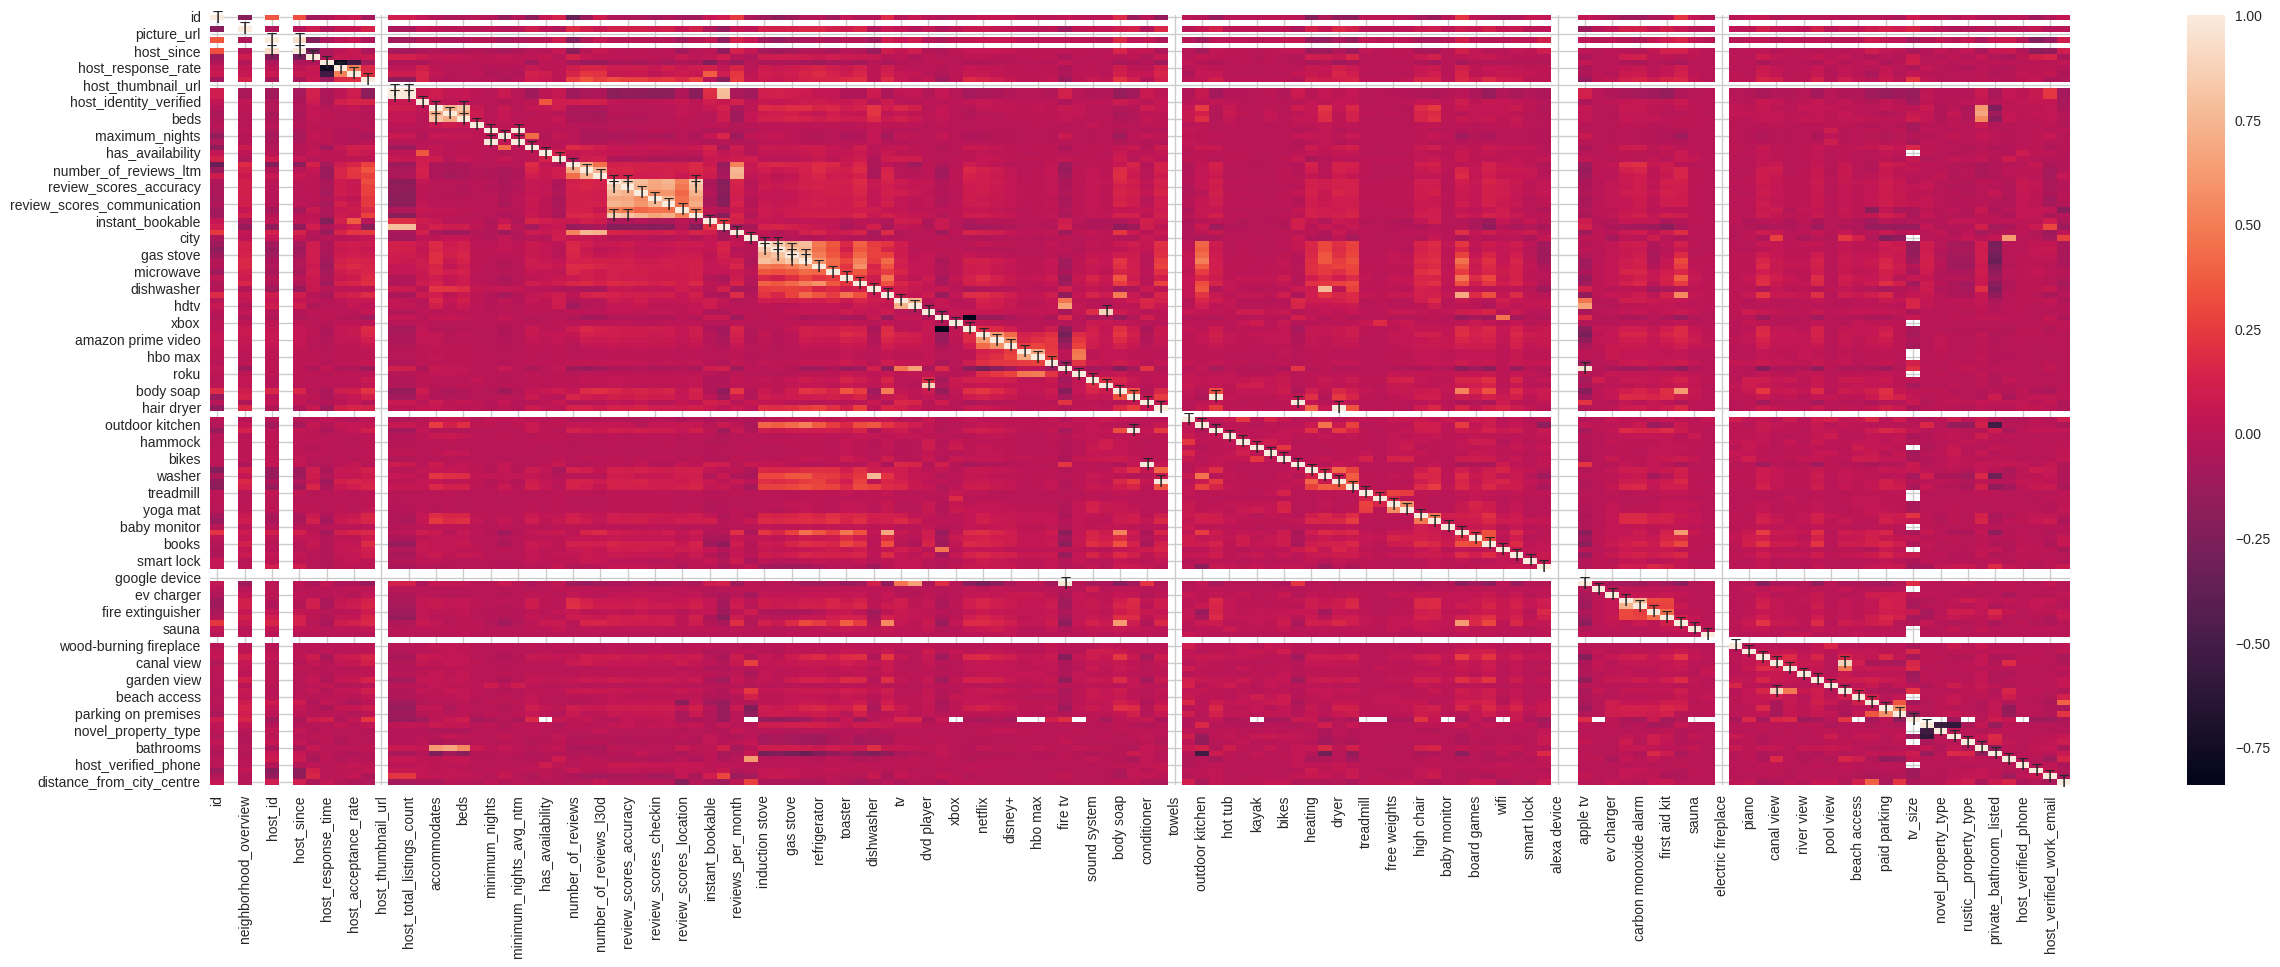

In [ ]:
#fig, ax = plt.subplots(figsize=(30, 10))
filtered_data = data.corr(method = "pearson").round(2)
#sns.heatmap(filtered_data, ax=ax, annot=True)

# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
annot_labels = np.empty_like(filtered_data, dtype=str)
annot_mask = filtered_data >= 0.8
annot_labels[annot_mask] = 'T'
# Plot heat map with the annotations
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(filtered_data, annot=annot_labels, fmt='')

## Select Attributes

When modelling the price, the review data should be removed to avoid a data leak.

Before the train and test data is split, it is feasible to do:
- Ordinal to numerical transform
- Add independent features
- Select features

But you cannot do:
- Add relative features
- Log transformation
- Feature scaling

# Modelling

We now it and test our models

## Further Preprocessing

In [ ]:
selected_data = data.copy()
#selected_data.drop('id', inplace=True, axis=1)


### Log Transform and Outlier Removal

In [ ]:
def log_transfer(X):
    skewness = X.skew().sort_values(ascending=False)
    skewed_cols = list(skewness[abs(skewness) > 1].index)

    for col in skewed_cols:
        X[col] = np.log(1+ X[col])

    return X


def log_transform(dataset): #X is parse_data[SALE_PRICE], Y should be parse_data['LOG_SALE_PRICE']
    dataset["log_price"] = np.log(1 + dataset["price"])

    return dataset

def remove_outliers(X, dataset): # X should be parsed_data['SALE_PRICE'], dataset is parsed_data
    z_scores = zscore(X)

    # Define a threshold of 3 standard deviations for defining outliers
    threshold = 2.5

    # Create a mask to identify outliers
    outlier_mask = (abs(z_scores) > threshold)

    # Make sure I'm not removing everything
    num_outliers = outlier_mask.sum()
    print("Number of outliers:", num_outliers) #Removes 255, leaves 73997 data points remaining - that's good

    # Filter out rows with outliers
    dataset = dataset[~outlier_mask]
    #Count after
    print("Number of rows after removing outliers:", dataset.shape[0])

    return dataset



In [ ]:

missing_values_count = selected_data.isnull().sum()

# Sort the attributes based on the count of missing values in descending order
missing_values_sorted = missing_values_count.sort_values(ascending=False)

# Display the sorted missing values counts
print("Attributes with missing values (sorted in descending order):")
print(missing_values_sorted.head(10))


Attributes with missing values (sorted in descending order):
tv_size                 19751
bedrooms                 3820
host_response_rate       1982
host_acceptance_rate     1216
host_is_superhost         608
beds                      104
bathrooms                  49
books                       0
crib                        0
baby monitor                0
dtype: int64


Due to the large number of missing values, the tv_size is removed before modelling. The entries with missing values will be remain, as XGBoost is able to handle missing values for some attributes.

In [ ]:
selected_data = log_transform(selected_data)

selected_data = remove_outliers(selected_data["log_price"], selected_data)

selected_data = selected_data.drop(columns=['tv_size'])



Number of outliers: 372
Number of rows after removing outliers: 19519


## Generic Training and Testing Code


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

def evaluate_model(y_test, y_pred, model, city, attribute_name):
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred)
  plt.xlabel(f'Real {attribute_name}')
  plt.ylabel(f'Predicted {attribute_name}')
  plt.title(f'Predicted vs Real {attribute_name} {city}')
  plt.show()
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"Root Mean Squared Error: {np.sqrt(mse)}")


  # Determine feature importance
  feature_importance = model.feature_importances_

  # Get indices of top 30 most important features
  top_indices = feature_importance.argsort()[-30:][::-1]

  # Get names of top 30 most important features
  top_features = X.columns[top_indices]

  # Get importance scores of top 30 most important features
  top_importance = feature_importance[top_indices]

  # Visualize top 30 most important features
  plt.figure(figsize=(10, 6))
  plt.barh(top_features, top_importance)
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Features')
  plt.title(f'Top 30 Most Important Features {city}')
  plt.show()

def train_and_evaluate(X, y, city, attribute_name = 'Price', log = True):
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Instantiate XGBoost Regressor model
  model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

  # Train the model
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  if log:
    y_pred_returned = np.exp(y_pred)
    y_test_returned = np.exp(y_test)

    evaluate_model(y_test_returned, y_pred_returned, model, city, attribute_name)
  else:
      evaluate_model(y_test, y_pred, model, city, attribute_name)


## Predicting Price

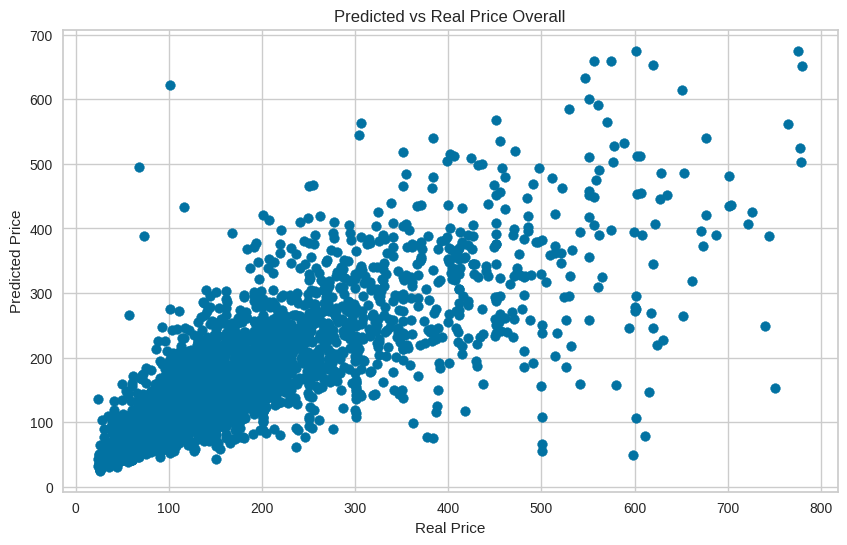

Mean Squared Error: 4841.224294159586
Mean Absolute Error: 41.88134826353339
Root Mean Squared Error: 69.57890696295527


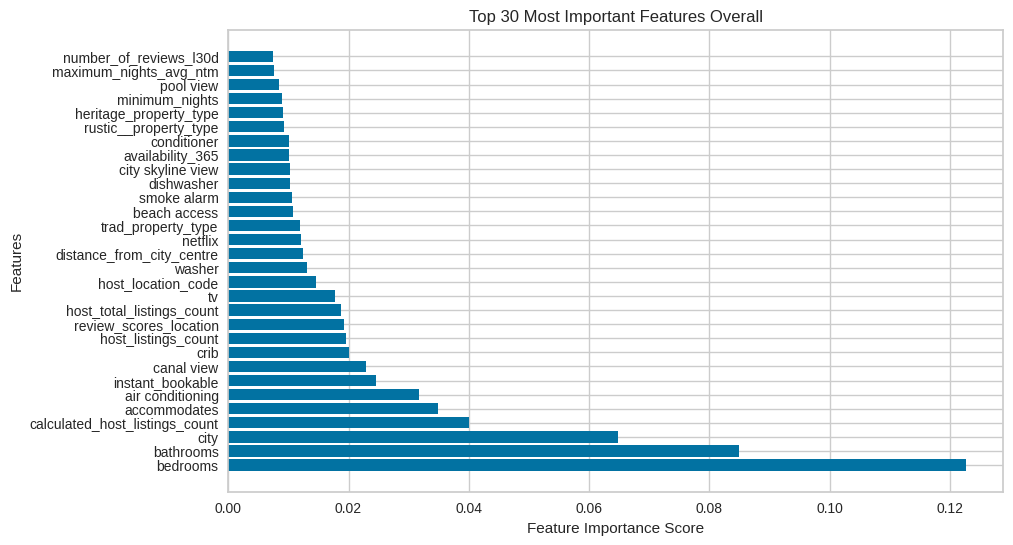

In [ ]:
X = selected_data.drop(columns=['price', 'log_price']) # Features
y = selected_data['log_price'] # Target variable

train_and_evaluate(X,y, 'Overall')

### Linear Baseline Model

Below we implement a linear baseline model to compare the performance. The performance is significantly worse than the XGBoost model, so this linear model is not explored any further.

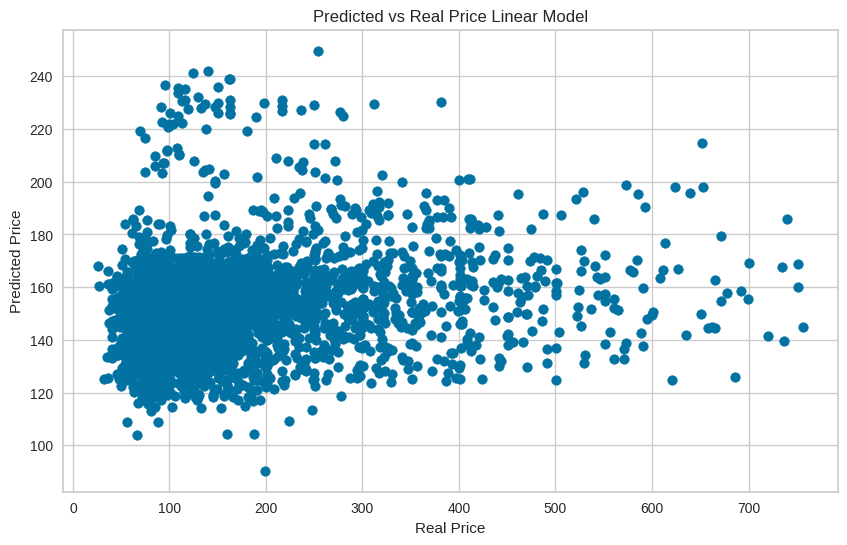

Mean Squared Error of Linear Model: 14591.48161497772
Mean Absolute Error of Linear Model: 81.89110665464642
Root Mean Squared Error of Linear Model: 120.79520526485196


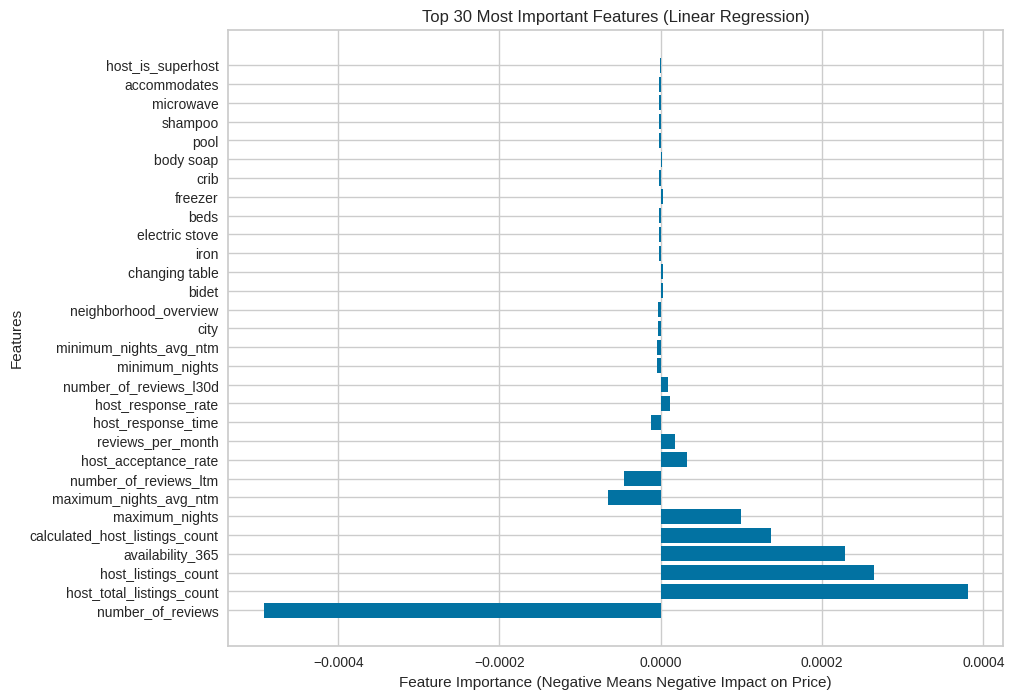

In [ ]:
noNan_data = selected_data.dropna()
X = noNan_data.drop(columns=['price', 'log_price']) # Features
y = noNan_data['log_price'] # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_returned = np.exp(y_test)

# Instantiate and train Linear Regression model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_linear = linear_model.predict(X_test)
y_pred_linear_returned = np.exp(y_pred_linear)
mse = mean_squared_error(y_test_returned, y_pred_linear_returned)
mae = mean_absolute_error(y_test_returned, y_pred_linear_returned)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_returned, y_pred_linear_returned)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title(f'Predicted vs Real Price Linear Model')
plt.show()
print(f"Mean Squared Error of Linear Model: {mse}")
print(f"Mean Absolute Error of Linear Model: {mae}")
print(f"Root Mean Squared Error of Linear Model: {np.sqrt(mse)}")


# Get the coefficients (weights) of the features
coefficients = linear_model.coef_

# Get the names of the features
feature_names = X_train.columns

# Pair the coefficients with their corresponding feature names
feature_importance_linear = dict(zip(feature_names, coefficients))

# Get the 30 most important features with their absolute values
top_features = sorted(feature_importance_linear.items(), key=lambda x: abs(x[1]), reverse=True)[:30]
top_feature_names = [feat[0] for feat in top_features]
top_feature_importance = [feat[1] for feat in top_features]


# Visualize the top 30 most important features
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Feature Importance (Negative Means Negative Impact on Price)')
plt.ylabel('Features')
plt.title('Top 30 Most Important Features (Linear Regression)')
plt.show()

### Models for Individual Cities
We will now create models for each of the three cities we are analyzing.

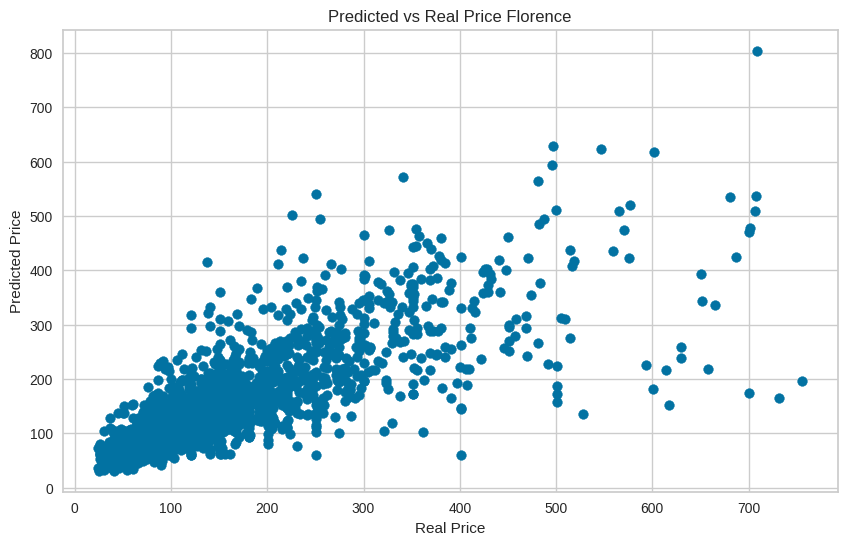

Mean Squared Error: 4388.243352310834
Mean Absolute Error: 39.760791120137256


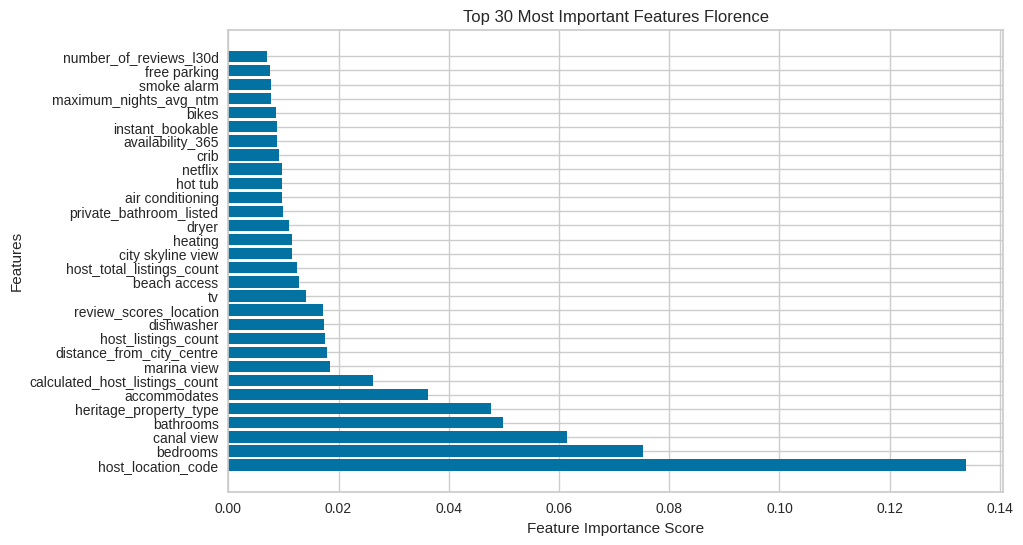

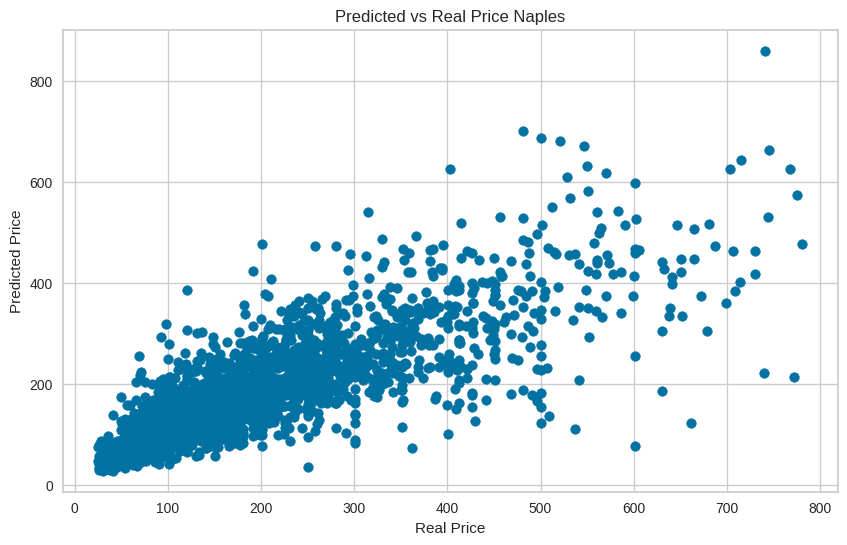

Mean Squared Error: 5450.296442523625
Mean Absolute Error: 47.00042509076247


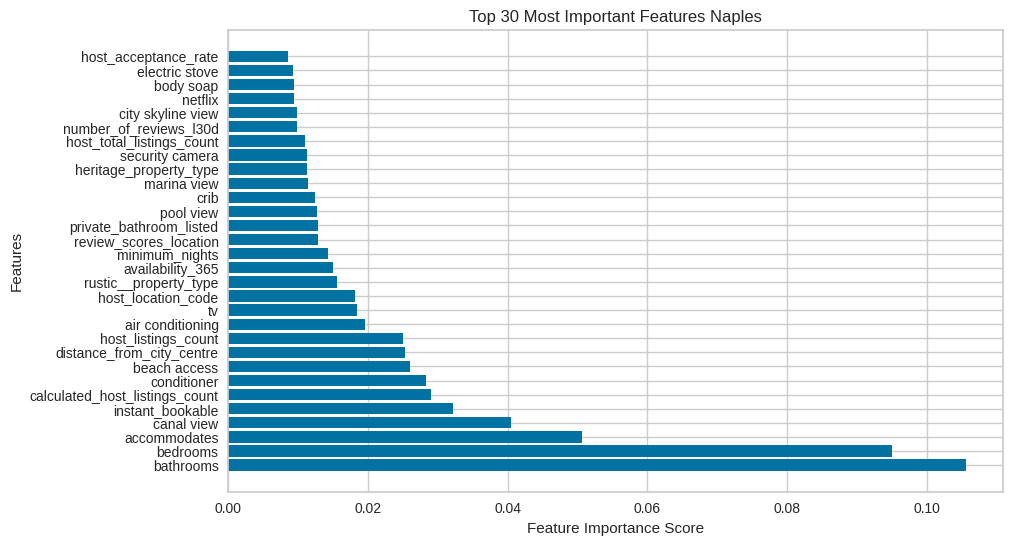

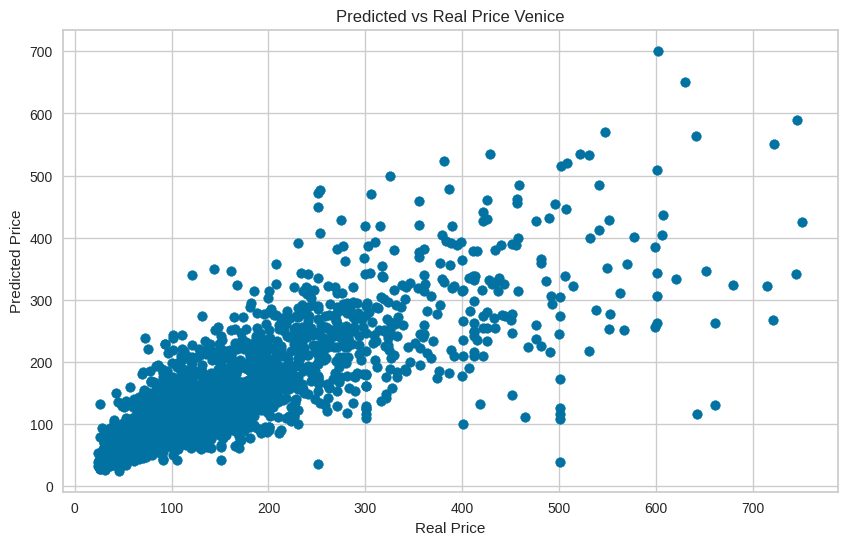

Mean Squared Error: 3993.606802789953
Mean Absolute Error: 38.09180983107209


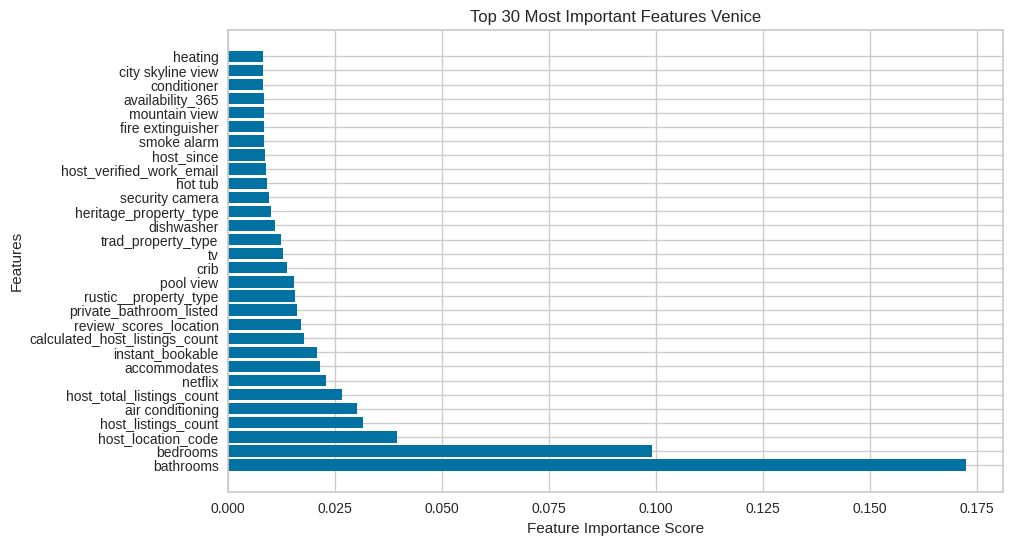

In [ ]:
city_map = {1: 'Florence', 2: 'Naples', 3: 'Venice'}


for city in [1,2,3]:
  city_data = selected_data[selected_data['city'] != city]

  X = city_data.drop(columns=['price', 'log_price', 'city']) # Features
  y = city_data['log_price'] # Target variable

  train_and_evaluate(X,y,city_map[city])


## Predicting Reviews

###  Overall Prediction

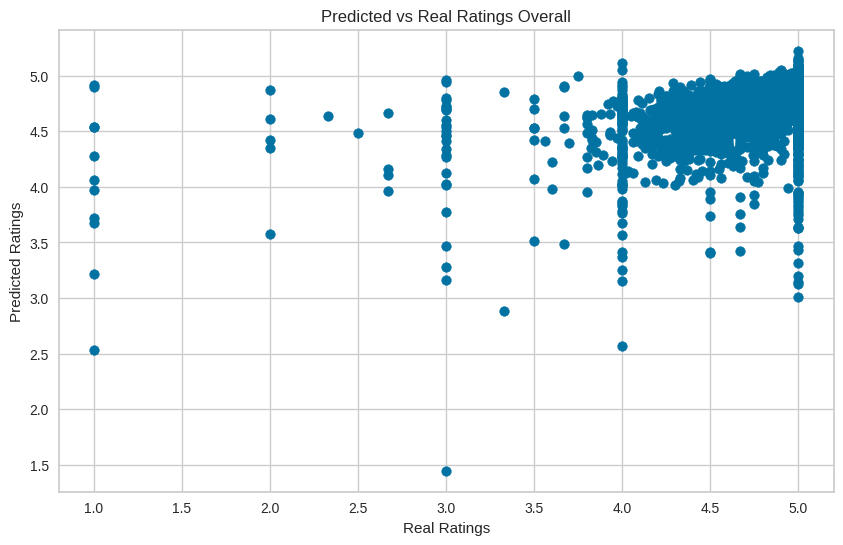

Mean Squared Error: 0.12241824286902075
Mean Absolute Error: 0.19435340032103612
Root Mean Squared Error: 0.34988318460454876


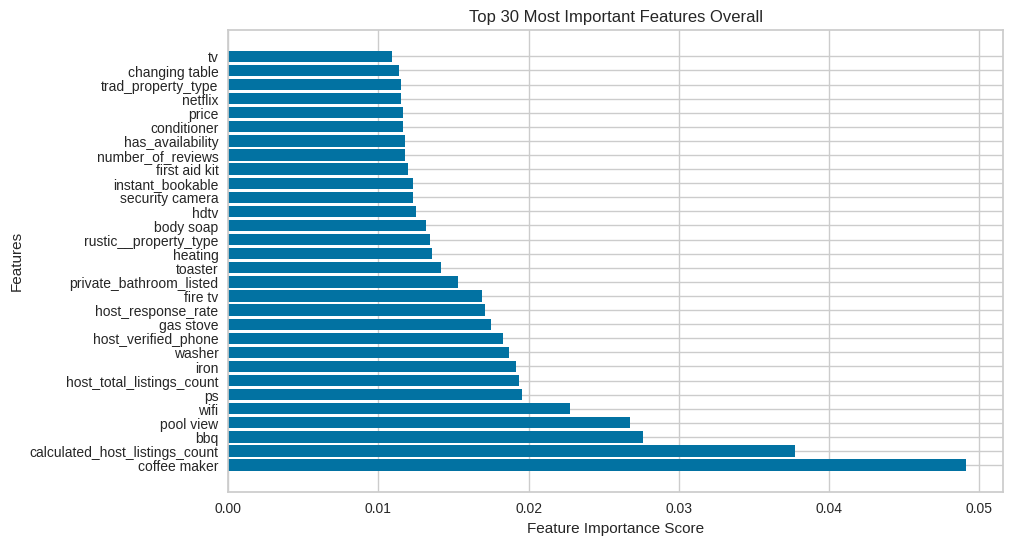

In [ ]:
X = selected_data.drop(columns=['review_scores_rating', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value','review_scores_communication', 'host_is_superhost', 'log_price']) # Features
y = selected_data['review_scores_rating'] # Target variable


train_and_evaluate(X,y, 'Overall', 'Ratings', False)

### Linear Baseline Model

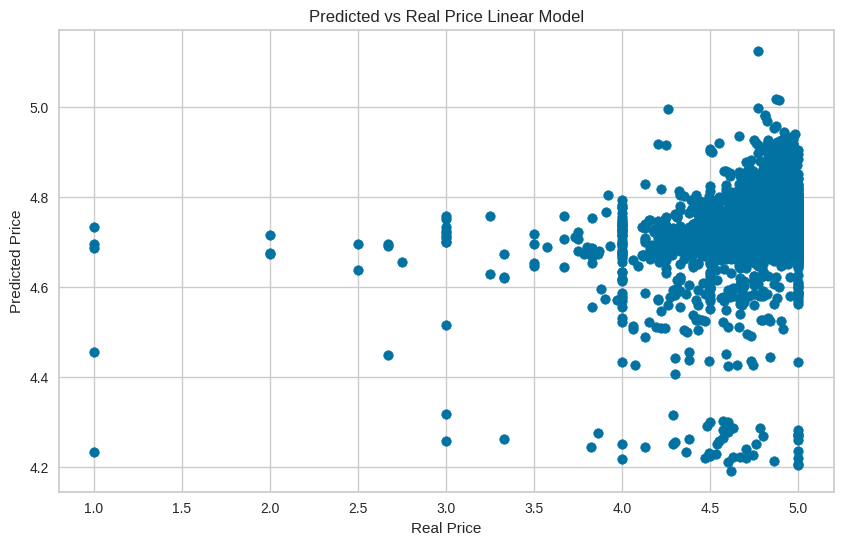

Mean Squared Error of Linear Model: 0.11203625274053852
Mean Absolute Error of Linear Model: 0.20321348821125487
Root Mean Square Error of Linear Model: 0.3347181691222311


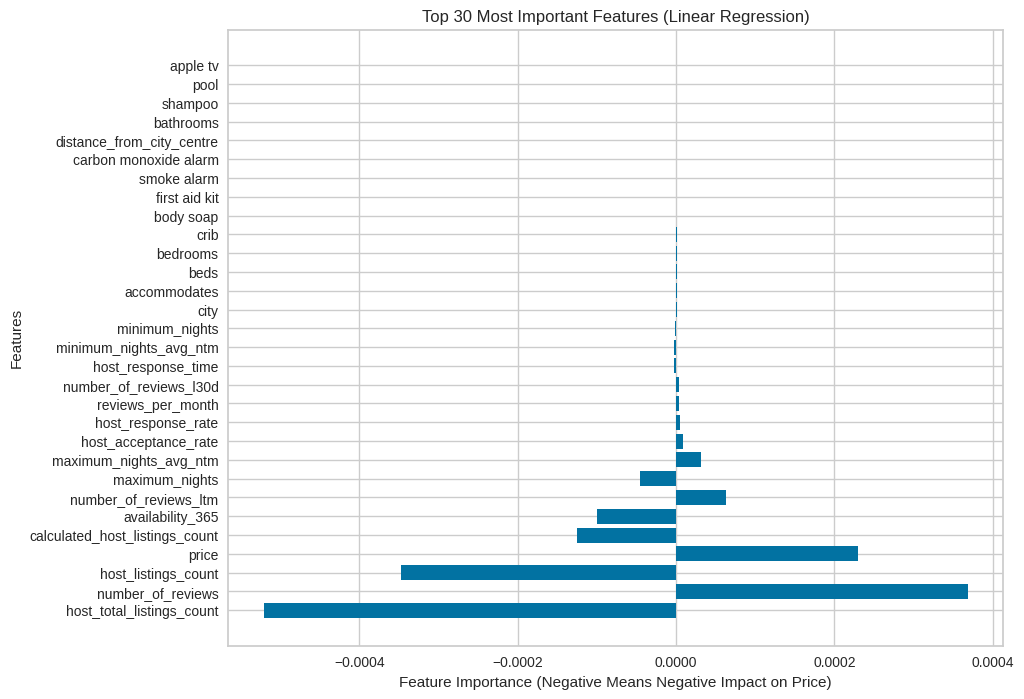

In [ ]:
noNan_data = selected_data.dropna()
X = noNan_data.drop(columns=['review_scores_rating', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value','review_scores_communication', 'host_is_superhost', 'log_price']) # Features
y = noNan_data['review_scores_rating'] # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train Linear Regression model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_linear = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_linear)
mae = mean_absolute_error(y_test, y_pred_linear)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title(f'Predicted vs Real Price Linear Model')
plt.show()

print(f"Mean Squared Error of Linear Model: {mse}")
print(f"Mean Absolute Error of Linear Model: {mae}")
print(f"Root Mean Square Error of Linear Model: {np.sqrt(mse)}")


# Get the coefficients (weights) of the features
coefficients = linear_model.coef_

# Get the names of the features
feature_names = X_train.columns

# Pair the coefficients with their corresponding feature names
feature_importance_linear = dict(zip(feature_names, coefficients))

# Get the 30 most important features with their absolute values
top_features = sorted(feature_importance_linear.items(), key=lambda x: abs(x[1]), reverse=True)[:30]
top_feature_names = [feat[0] for feat in top_features]
top_feature_importance = [feat[1] for feat in top_features]


# Visualize the top 30 most important features
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Feature Importance (Negative Means Negative Impact on Price)')
plt.ylabel('Features')
plt.title('Top 30 Most Important Features (Linear Regression)')
plt.show()

### Predicting for Individual Cities

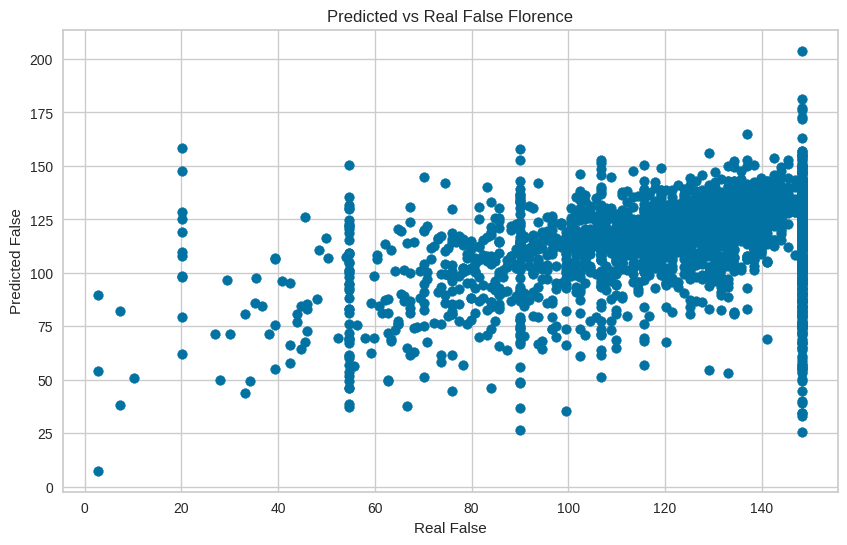

Mean Squared Error: 749.2869046160431
Mean Absolute Error: 19.616096026618425


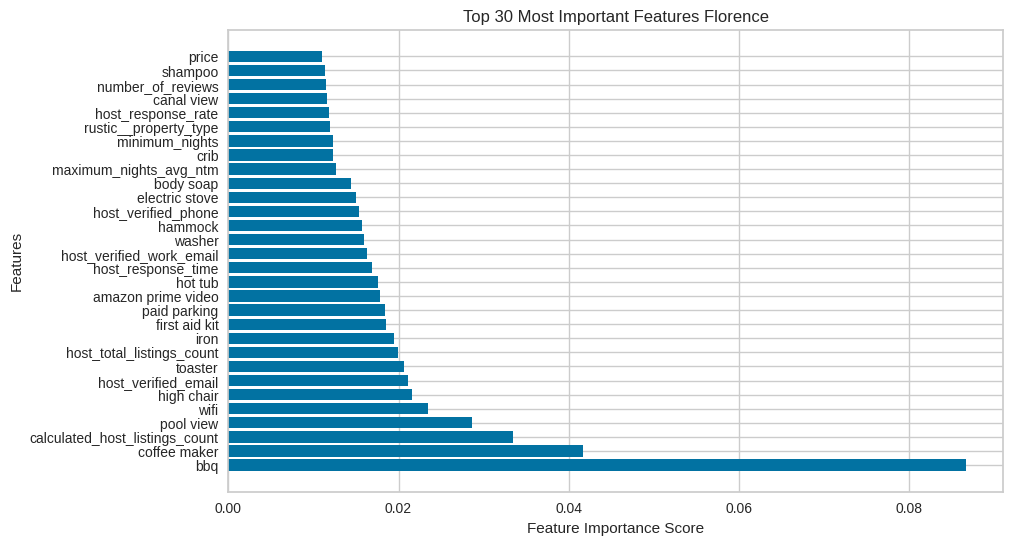

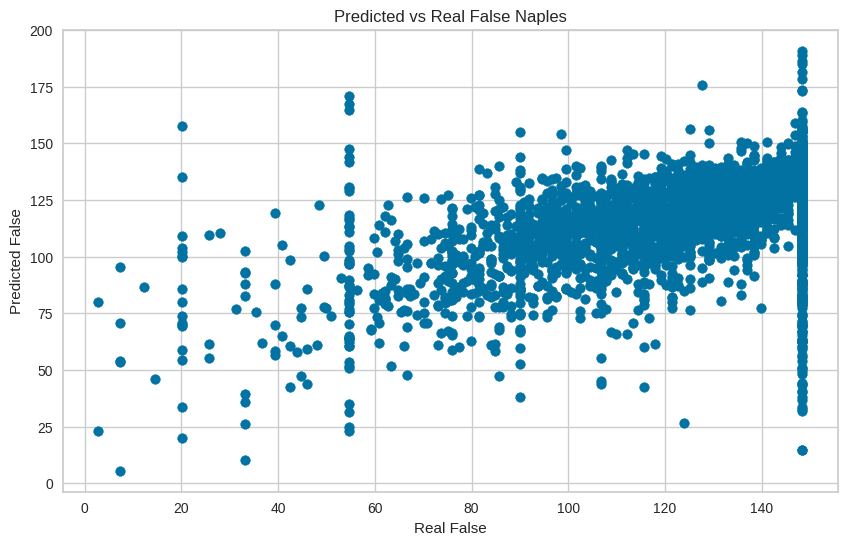

Mean Squared Error: 634.4605823454976
Mean Absolute Error: 17.690816549577374


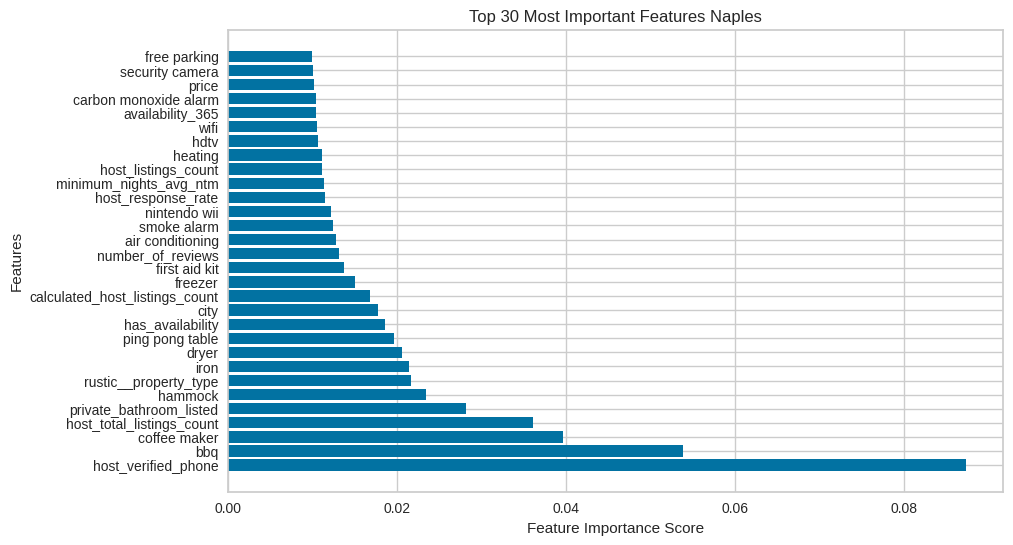

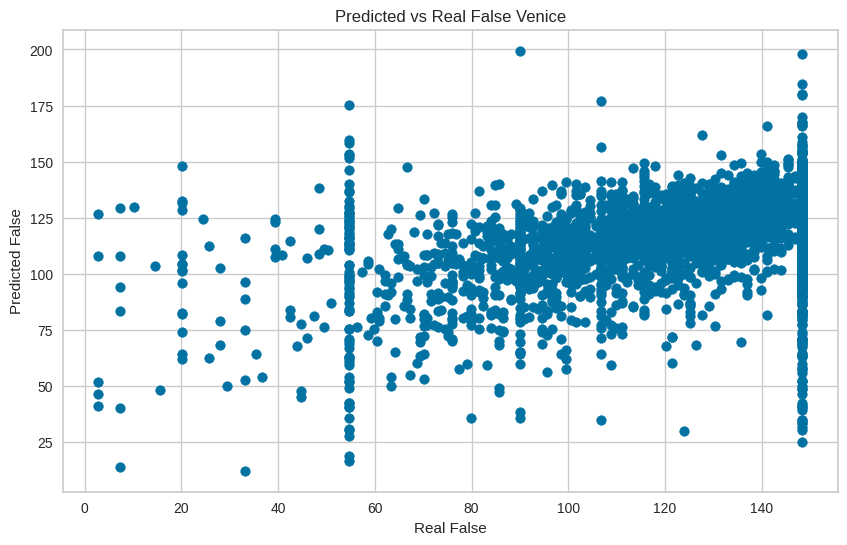

Mean Squared Error: 767.1851458147098
Mean Absolute Error: 19.626226547193646


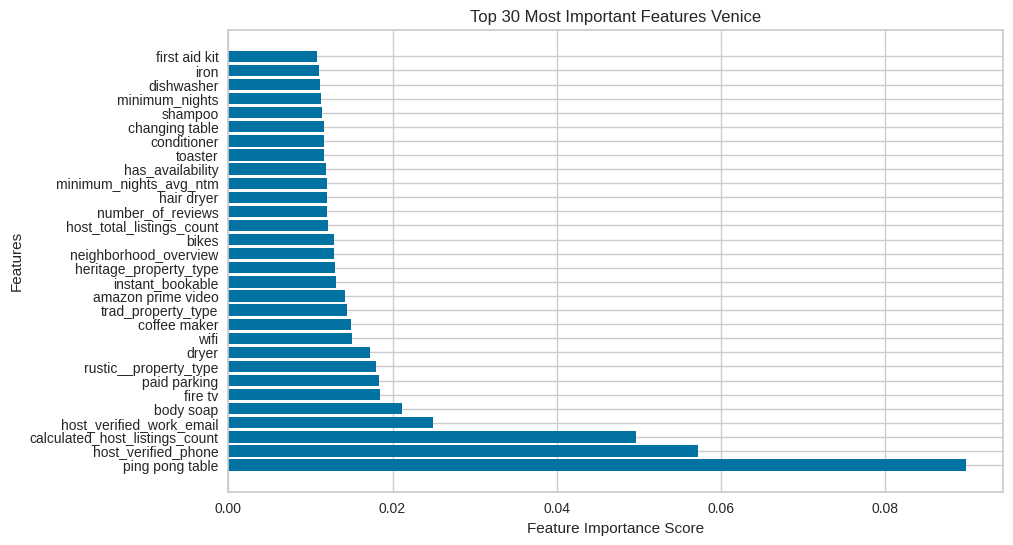

In [ ]:
for city in [1,2,3]:
  city_data = selected_data[selected_data['city'] != city]

  X = city_data.drop(columns=['review_scores_rating', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value','review_scores_communication', 'host_is_superhost', 'log_price']) # Features
  y = city_data['review_scores_rating'] # Target variable

  train_and_evaluate(X,y,city_map[city], False)